# **Strategic Stock Investment Analysis: Comparing Buy-and-Hold with Momentum Trading within Modern Portfolio Theory**











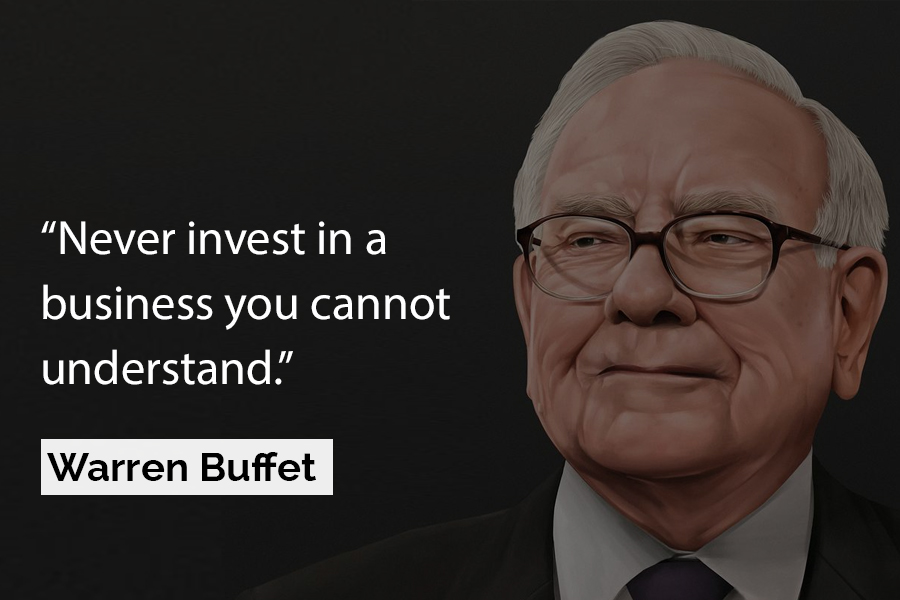

# Import Libs

Imported Python libraries like Pandas, NumPy, and Seaborn,for data manipulation and visualization and also we imported Pyomo with IPOPT solver for optimization tasks, and integrated Yahoo Finance for insightful stock analysis.


In [ ]:
# import modules in the Python program
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
import shutil
import sys
import os.path
import pandas_datareader as pdr
from datetime import datetime
import time
import warnings

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# import packages that are specific to stock analysis or trading.
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

pd.options.mode.chained_assignment=None
pd.set_option('display.float_format', '{:.5f}'.format)






Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 114MB/s]


# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

**10 Stocks From Each Sector:**

---
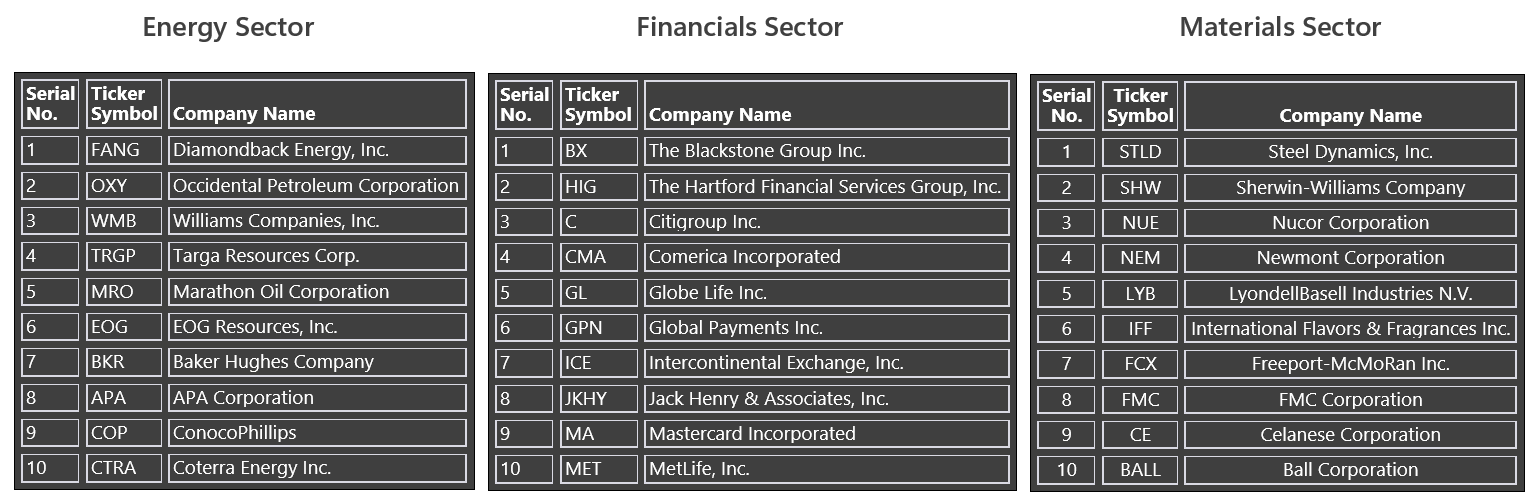

### 1.1.1 Data Retrieval

In this code segment, historical stock price data is being collected for a comprehensive list of 30 ticker symbols, representing companies across various industries. These tickers are detailed in the previous section and include 10 stocks from each of three different sectors. The data covers a five-year period, spanning from January 1, 2017, to December 31, 2021, with prices gathered on a daily basis. The 'stock_price' dictionary created by this process is structured to store the price data for each ticker, providing a ready-to-use resource for subsequent analysis. This historical price data is essential for conducting in-depth financial analysis and may be used to correlate market performance with external factors.

In [ ]:
#data retrieval

# Assign the ticker list that we to collect from a data source
tickers_list = ['FANG','OXY','WMB','TRGP','MRO','EOG','BKR','APA','COP','CTRA','BX','HIG','C','CMA','GL','GPN','ICE','JKHY','MA','MET','STLD','SHW','NUE','NEM','LYB','IFF','FCX','FMC','CE','BALL']
# Retrieve historical price data for each stock, which will later be matched up with a news score
stock_price = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}
stock_price

{'FANG':                 open      high       low     close  adjclose   volume ticker
 2017-01-03 102.50000 104.99000 102.05000 103.25000  85.76510  1287500   FANG
 2017-01-04 103.25000 104.84000 102.47000 103.57000  86.03091  1250200   FANG
 2017-01-05 103.93000 105.56000 102.81000 103.67000  86.11396  1053100   FANG
 2017-01-06 103.64000 104.79000 102.05000 103.66000  86.10565  1012000   FANG
 2017-01-09 102.91000 103.00000 101.29000 101.43000  84.25331   658600   FANG
 ...              ...       ...       ...       ...       ...      ...    ...
 2021-12-23 106.00000 107.40000 105.24000 105.94000  94.06467  1639900   FANG
 2021-12-27 105.93000 111.22000 104.12000 111.14000  98.68177  2062700   FANG
 2021-12-28 111.62000 112.33000 109.08000 110.16000  97.81163  1408400   FANG
 2021-12-29 109.94000 111.22000 108.52000 108.71000  96.52416  1256500   FANG
 2021-12-30 108.71000 109.91000 107.17000 107.31000  95.28110  1231300   FANG
 
 [1258 rows x 7 columns],
 'OXY':                open 

### 1.1.2 Data Cleaning

The data cleaning step involves extracting the 'adjclose' prices from our dataset, which are vital for financial analysis. Starting with 'FANG', we create a dataframe of adjusted close prices and then append the equivalent data for the other companies in our tickers list. The resulting 'prep_data' dataframe is a consolidated collection of these prices, structured for easy access and analysis.

In [ ]:
#DATACLEANING
# Let's extract only the "adjclose" data that is needed for analysis, likely from the dataset
# Get the adjclose price for BXP
prep_data = pd.DataFrame(stock_price['FANG']['adjclose']).rename(columns = {"adjclose":"FANG"})

#Combine the remaining selected companies ticker symbols
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(stock_price[i]['adjclose'])
prep_data

,FANG,OXY,WMB,TRGP,MRO,EOG,BKR,APA,COP,CTRA,...,STLD,SHW,NUE,NEM,LYB,IFF,FCX,FMC,CE,BALL
2017-01-03,85.76510,58.58588,21.02526,41.41793,16.18853,83.01090,37.29226,55.33754,40.61520,17.42972,...,31.13475,85.85169,50.61177,28.43168,59.75439,98.51128,12.85087,44.12682,68.40188,35.32973
2017-01-04,86.03091,57.94545,20.95843,41.62510,16.45287,83.07501,37.13168,55.17268,40.99240,17.45312,...,32.48469,86.43333,52.00421,28.70263,61.06806,98.69624,13.83007,45.03984,69.52887,35.86608
2017-01-05,86.11396,57.24830,21.21238,42.13943,16.57136,83.52398,36.90230,54.87768,40.87200,17.66377,...,32.66526,86.36453,51.70704,30.02447,60.99242,97.61166,13.63423,45.21006,69.46864,35.84743
2017-01-06,86.10565,57.62121,21.66684,42.43945,16.29790,84.34976,36.67865,54.76488,40.71954,17.85882,...,31.61626,87.24324,51.18913,29.08029,60.64163,97.54440,13.89536,45.12495,69.70950,36.00600
2017-01-09,84.25331,57.13480,21.33936,41.86083,15.86038,82.59399,36.26577,54.10550,39.85282,17.23466,...,31.04017,87.17133,50.63725,29.03104,59.76128,97.15765,13.69019,44.83867,69.30518,35.43700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,94.06467,28.27394,23.26933,48.58627,15.54829,78.21815,23.03558,25.03137,65.19900,16.93719,...,59.63541,331.87885,110.84599,54.95679,78.10468,133.87607,39.83197,104.56493,153.94643,87.61408
2021-12-27,98.68177,29.04817,23.63840,50.24055,16.09248,81.44808,23.41603,26.85567,67.04900,17.39141,...,60.68979,338.91104,113.12497,55.55685,79.07075,136.61380,40.66483,104.40202,156.34171,89.48318
2021-12-28,97.81163,28.89136,23.54839,50.04930,16.01473,80.94566,23.37798,26.81727,66.96658,17.43509,...,60.26417,341.70627,110.99144,55.65841,79.97643,138.71179,40.66483,104.99615,157.91624,91.80009
2021-12-29,96.52416,28.67576,23.44037,49.66680,16.10219,80.61369,23.08314,26.79806,66.78340,17.47876,...,60.33188,344.60944,111.41816,55.96305,79.93330,140.17003,40.65514,104.83324,159.44316,92.70544


To calculate daily return features for stocks in tickers_list, we apply percentage change to prep_data. These returns are stored in return_data, and any null values are removed to ensure data consistency.

In [ ]:
# Create return features for each ticker,
# We will use percentage change(pct_change) calculation as the return metric for the stocks being analyzed
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# Drop the null values in the dataset
return_data.dropna(inplace=True)
return_data

,FANG,OXY,WMB,TRGP,MRO,EOG,BKR,APA,COP,CTRA,...,STLD,SHW,NUE,NEM,LYB,IFF,FCX,FMC,CE,BALL
2017-01-04,0.00310,-0.01093,-0.00318,0.00500,0.01633,0.00077,-0.00431,-0.00298,0.00929,0.00134,...,0.04336,0.00677,0.02751,0.00953,0.02198,0.00188,0.07620,0.02069,0.01648,0.01518
2017-01-05,0.00097,-0.01203,0.01212,0.01236,0.00720,0.00540,-0.00618,-0.00535,-0.00294,0.01207,...,0.00556,-0.00080,-0.00571,0.04605,-0.00124,-0.01099,-0.01416,0.00378,-0.00087,-0.00052
2017-01-06,-0.00010,0.00651,0.02142,0.00712,-0.01650,0.00989,-0.00606,-0.00206,-0.00373,0.01104,...,-0.03211,0.01017,-0.01002,-0.03145,-0.00575,-0.00069,0.01915,-0.00188,0.00347,0.00442
2017-01-09,-0.02151,-0.00844,-0.01511,-0.01363,-0.02685,-0.02082,-0.01126,-0.01204,-0.02129,-0.03495,...,-0.01822,-0.00082,-0.01078,-0.00169,-0.01452,-0.00396,-0.01477,-0.00634,-0.00580,-0.01580
2017-01-10,0.01262,-0.01603,-0.10742,-0.02696,0.00460,0.00369,-0.01360,0.00818,0.00000,0.00362,...,0.02853,0.00043,0.02649,-0.00792,-0.00012,-0.00069,0.05926,-0.00431,0.00956,-0.00474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.00237,-0.00242,0.00662,-0.00138,-0.00249,-0.00046,0.01254,0.00929,0.00155,-0.01823,...,0.00325,-0.00100,0.00581,0.01761,0.02874,0.00612,0.02466,0.01507,0.01160,-0.00033
2021-12-27,0.04908,0.02738,0.01586,0.03405,0.03500,0.04129,0.01652,0.07288,0.02837,0.02682,...,0.01768,0.02119,0.02056,0.01092,0.01237,0.02045,0.02091,-0.00156,0.01556,0.02133
2021-12-28,-0.00882,-0.00540,-0.00381,-0.00381,-0.00483,-0.00617,-0.00162,-0.00143,-0.00123,0.00251,...,-0.00701,0.00825,-0.01886,0.00183,0.01145,0.01536,0.00000,0.00569,0.01007,0.02589
2021-12-29,-0.01316,-0.00746,-0.00459,-0.00764,0.00546,-0.00410,-0.01261,-0.00072,-0.00274,0.00250,...,0.00112,0.00850,0.00384,0.00547,-0.00054,0.01051,-0.00024,-0.00155,0.00967,0.00986


In [ ]:
return_data.shape

(1257, 30)

## 1.2 Time-Series Visualization of Stocks Values by Sector


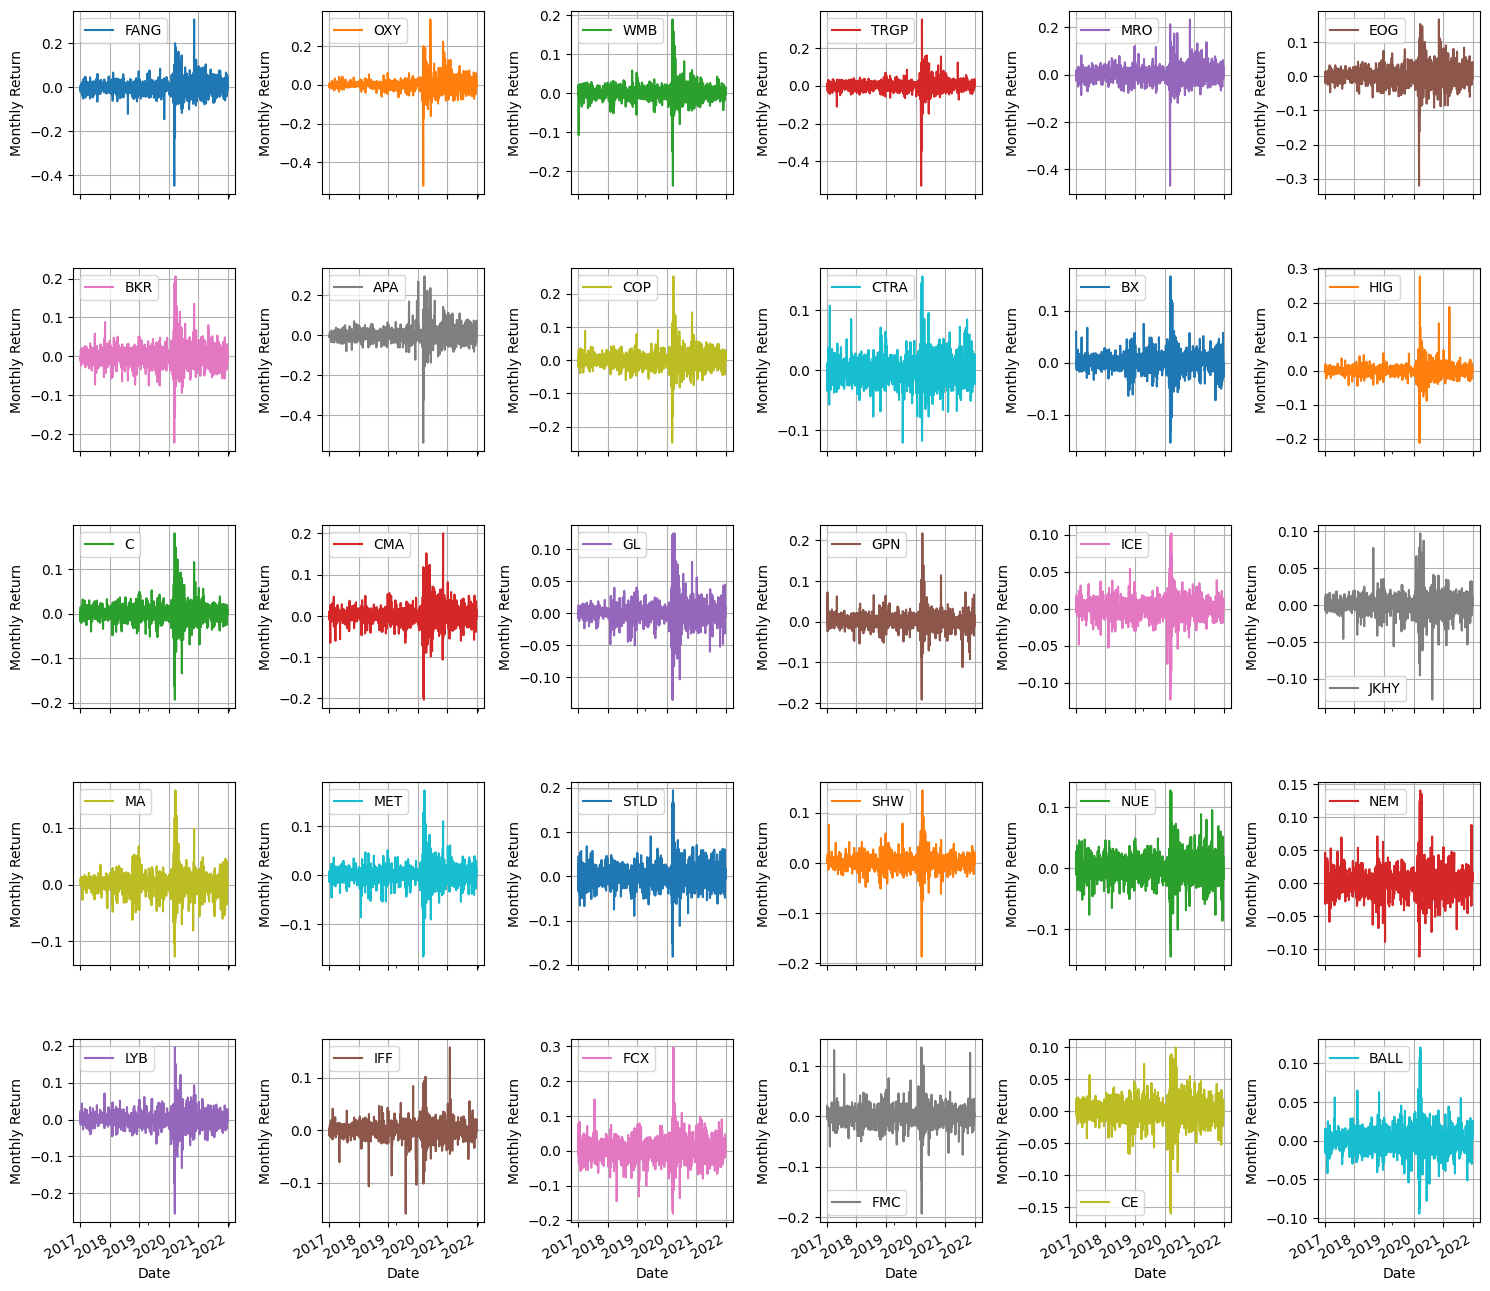

In [ ]:
# Display monthly return data, with each subplot displaying the return data for a different ticker
return_data.plot(subplots=True,
        grid=True,
        layout=(6,6),
        xlabel='Date',
        ylabel='Monthly Return',
         figsize=(15,15))
plt.tight_layout()
plt.show()

Above result shows a series of subplots, each representing the monthly return data for different ticker symbols. In each subplot, the x-axis represents the time period from 2017 to 2021, and the y-axis indicates the monthly return, showcasing the fluctuations in stock performance. The varied spikes and dips across the charts reflect the volatility and unique return profiles of each stock, providing insights into their behavior over the specified timeframe.

**Function to Visualize Sector-Specific Stock Value Over Time**

In [ ]:
def plot_sector_data(data, columns, sector_name):
    # Selecting relevant columns from the DataFrame
    sector_data = data.loc[:, columns]

    # Plotting the data
    sector_data.plot(figsize=(14, 7))

    # Adding labels and title
    plt.xlabel('Year')
    plt.ylabel('Daily Return')
    plt.title(f'Value of the stocks over time - {sector_name} Sector')


    # Display the plot
    plt.show()


### 1.2.1 Energy Sector: Stock Value Over Time


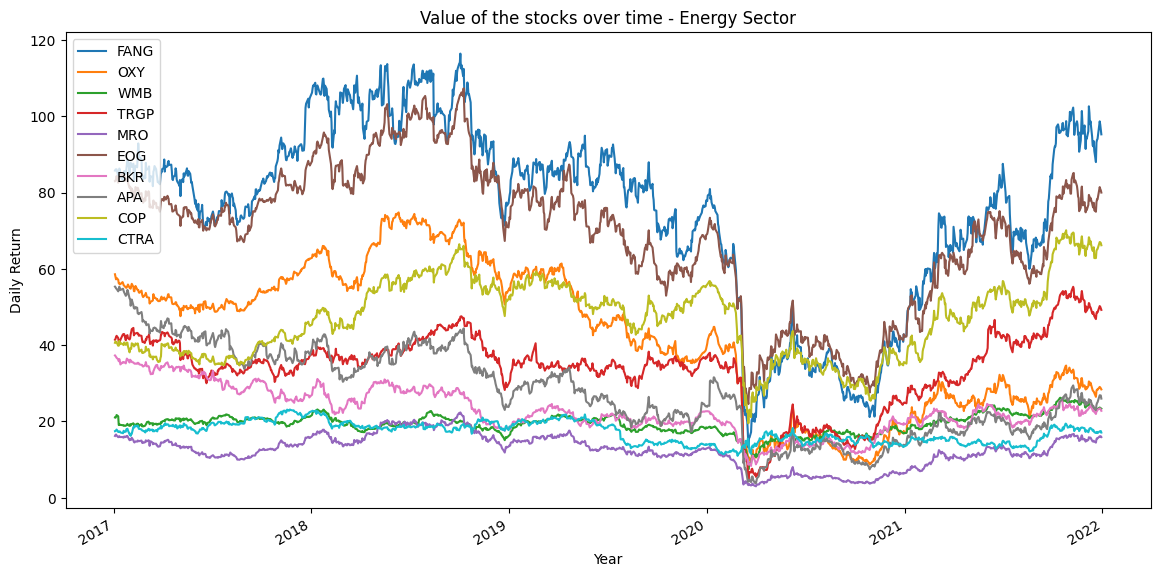

In [ ]:
plot_sector_data(prep_data, prep_data.columns[:10], 'Energy')


The time-series graph for the Energy sector displays the daily returns of various stocks from 2017 to 2022, with each stock demonstrating unique performance characteristics. 'FANG', demonstrates a stable and generally upward trend, indicating consistent performance. 'OXY', shows substantial volatility with notable downturns, especially around 2020, highlighting periods of significant market stress. 'WMB', displays more consistent returns with less volatility, suggesting steadier performance. 'TRGP', is characterized by high volatility, with its value fluctuating greatly over the observed period. 'MRO' and 'EOG'along with 'BKR' ,'APA' , 'COP' , and 'CTRA' , each show varying degrees of volatility and recovery, particularly after the 2020 market slump.

### 1.2.2 Finance Sector: Stock Value Over Time


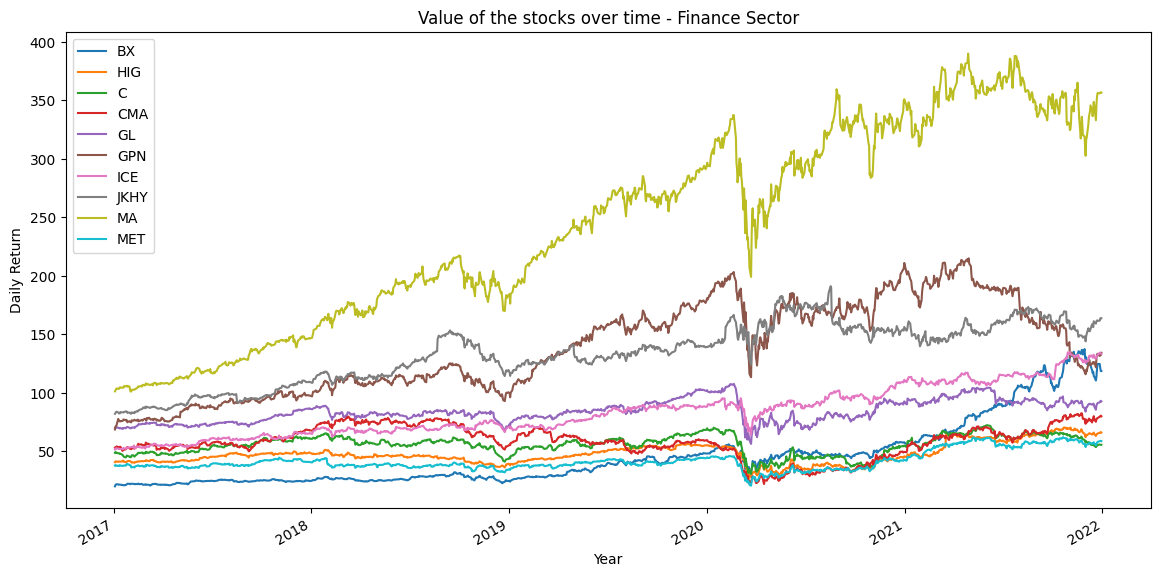

In [ ]:
plot_sector_data(prep_data, prep_data.columns[10:20], 'Finance')


The graph of the Finance sector reveals diverse trajectories for each stock from 2017 to 2022. Notably, 'MA' outperforms others with exceptional growth, gaining back from the drop in 2020, showcasing its robustness and earning potential within the Finance sector.'BX'  displays a notable upward trend, with significant growth post-2020. 'HIG'  and 'C' both encounter volatility and a sharp decline during 2020, followed by a recovery, although they do not attain the same growth levels as 'BX'. 'CMA' , 'GL' , and 'MET' demonstrate resilience with a dip in 2020, yet recover with varying degrees of success. 'GPN'  and 'ICE' show strong growth until the pandemic, followed by a marked recovery, while 'JKHY' maintains a steady upward trend with less volatility.

### 1.2.3 Materials Sector: Stock Value Over Time


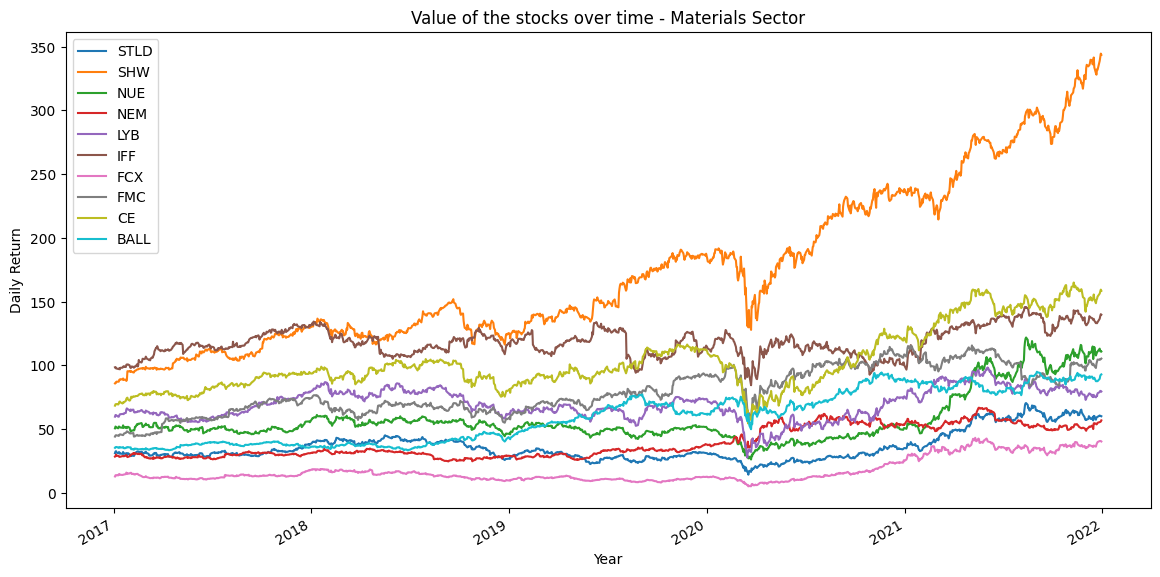

In [ ]:
plot_sector_data(prep_data, prep_data.columns[20:], 'Materials')

The graph illustrates the daily returns of stocks within the Materials sector from 2017 to 2022. 'SHW' exhibits a prominent upward trend, significantly outperforming other stocks in the sector with steady growth and minimal volatility, indicating strong and consistent returns. 'NUE'  and 'STLD'  also show an overall increase in their returns, but with more fluctuations, especially during the 2020 downturn, from which they both recover well. 'NEM'  and 'LYB' present a more volatile journey with peaks and troughs, yet maintain an upward trajectory over the long term. 'IFF' , 'FCX' , 'FMC' , and 'CE' (in teal) display varied patterns of growth, with 'FCX' in particular showing a sharp recovery post-2020. 'BALL'  demonstrates the least volatility, with a steady rise in returns throughout the period. This sector graph indicates a strong recovery and growth post-2020 across most of the stocks, showcasing the sector's resilience and potential for investor returns.

## 1.3 Conclusion On Plots

##Based on the three sector graphs, here are the conclusions for each:

**Energy Sector:**

Energy stocks showed considerable volatility around 2020, reflecting the sector's sensitivity to global events like the COVID-19 pandemic.
'FANG' and 'EOG' demonstrated strong growth patterns, indicating robust performance within the sector.
Post-2020, many stocks recovered, with 'COP' and 'CTRA' displaying significant rebounds, suggesting potential for long-term growth.

**Finance Sector:**

Finance stocks exhibited volatility during 2020, with varying degrees of recovery afterward.
'MA' stood out with exceptionally high returns, particularly after 2020, underscoring its strong market position.
'BX' also showed substantial growth, while other stocks like 'C' and 'HIG' faced downturns but later recovered to some extent.

**Materials Sector:**

'SHW' presented a notable steady upward trend, outperforming others in the sector with consistent growth.
The sector as a whole showed resilience, with many stocks, including 'NUE' and 'STLD', recovering well after the initial shock of the pandemic.

In summary, while all three sectors faced challenges around 2020, the overall trend indicates recovery and growth, with certain stocks in each sector standing out as strong performers.

# 2 - Momentum Trading for Stock Selection
This strategy focuses on capitalizing on the continuation of these trends, using technical analysis and historical performance data. It compares 8-day and 21-day moving averages of a stock's closing price. The basic principle is to identify a momentum signal when the shorter-term (8-day) moving average crosses above the longer-term (21-day) moving average, indicating a buying opportunity, and vice versa for a selling signal.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

## 2.1 Momentum Trading Strategy
##**Function for Momentum Trading Strategy**

We applied a momentum trading strategy to evaluate a range of stocks throughout 2021. We made things easier by using a Python function that automatically gathered data, calculated averages, and found important trading patterns for us.It also displays top 3 stocks based on each sector.

In [ ]:
def plot_momentum_strategy(tickers, start_date, end_date):
    # Set up the plot
    final_returns = {}
    plt.figure(figsize=(14, 7))

    # Define a color palette
    colors = plt.cm.get_cmap('tab10', len(tickers))
    for idx, ticker in enumerate(tickers):
        tck = si.get_data(ticker, start_date=start_date, end_date=end_date, interval='1d')
        day = np.arange(1, len(tck) + 1)  # generate list of trading days
        tck['Day'] = day

        # Dropping columns not needed
        tck.drop(columns=['adjclose', 'volume', 'ticker'], inplace=True)

        # Reorganizing and renaming the columns
        tck = tck[['Day', 'open', 'high', 'low', 'close']]
        tck.columns = ['Day', 'Open', 'High', 'Low', 'Close']

        # Calculating moving averages
        tck['8-day'] = tck['Close'].rolling(8).mean().shift()
        tck['21-day'] = tck['Close'].rolling(21).mean().shift()
        tck.dropna(inplace=True)

        # Log close and return
        tck['logClose'] = np.log(tck['Close'])
        tck['return'] = tck['logClose'].diff().fillna(0)

        # Trading signals
        tck['invested'] = np.where(tck['8-day'] > tck['21-day'], 1, 0)
        tck['signal'] = tck['invested'].diff().fillna(1.0)

        # System return
        tck['system_return'] = tck['invested'] * tck['return']

        # Plot with the specified color
        final_returns[ticker] = np.exp(np.sum(tck['system_return'])) - 1
        plt.plot(np.exp(tck['system_return']).cumprod(), label=ticker, color=colors(idx))

    plt.legend(loc='best')
    plt.grid(True, alpha=.3)
    plt.title('Momentum Trading Strategy Performance')
    plt.xlabel('Day')
    plt.ylabel('Cumulative System Return')
    plt.show()

    # Determine the top 3 stocks
    top_3_stocks = sorted(final_returns, key=final_returns.get, reverse=True)[:3]
    return [(stock, final_returns[stock]) for stock in top_3_stocks]

### 2.1.1 Momentum Trading Strategy for Energy Sector
In Energy Sector, we focused on the following tickers: 'FANG', 'OXY', 'WMB', 'TRGP', 'MRO', 'EOG', 'BKR', 'APA', 'COP', and 'CTRA'. The outcome of this process was the identification of the top three stocks, stored in top_3_stocks.

<ipython-input-80-625a95fe49ca>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(tickers))


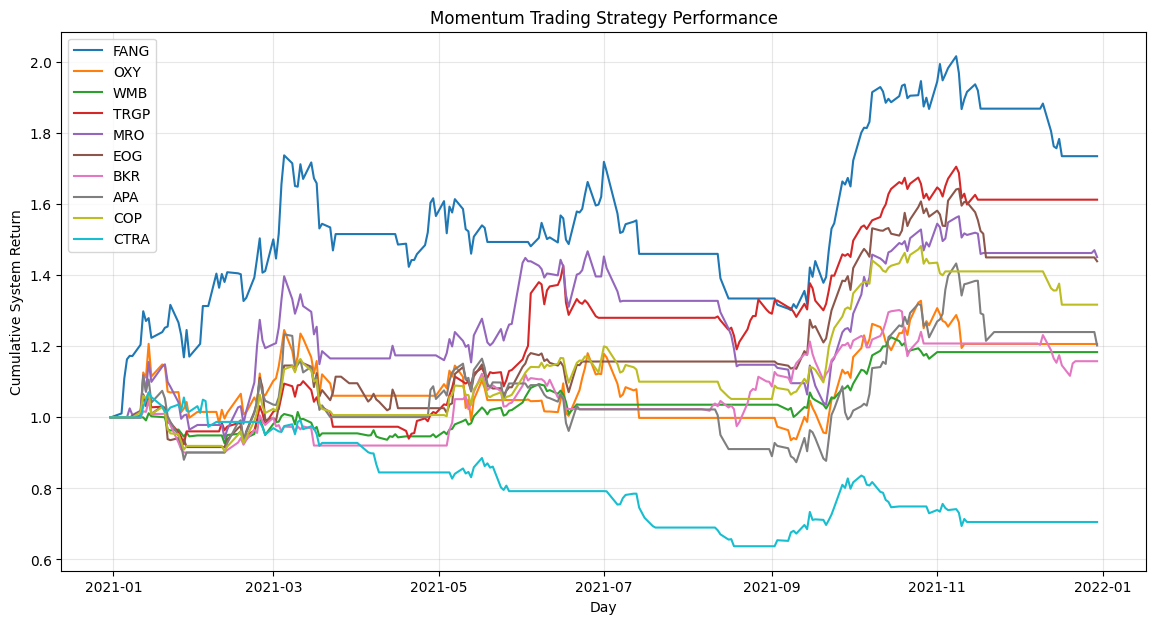

In [ ]:
energy_tickers = 'FANG','OXY','WMB','TRGP','MRO','EOG','BKR','APA','COP','CTRA'
top_3_stocks= plot_momentum_strategy(energy_tickers, '2020-12-01', '2021-12-31')

The graph illustrates the performance of various energy stocks over 2021 using a momentum strategy. TRGP leads with the most substantial increase, peaking at an impressive 80% return. EOG follows with a strong peak at 57%, while MRO also shows robust performance with a return just shy of 50%. Other notable stocks include OXY and COP, which peak at around 40% and 20% returns, respectively. APA peaks at 30% but then drops closer to its starting level by year's end, whereas FANG remains steady, with only a slight increase above its initial value, indicating minimal overall growth.

#### Top 3 stocks in Energy Sector

In [ ]:
print("Top 3 Stocks based on final cumulative returns:")
for stock, return_value in top_3_stocks:
    print(f"{stock}: {return_value*100:.2f}%")

Top 3 Stocks based on final cumulative returns:
FANG: 73.56%
TRGP: 61.31%
MRO: 45.14%


####**Top 3 stocks from the above results(Energy Sector):**
*FANG, TRGP, MRO*

**FANG:** Diamondback Energy is listed as the top performer with a final cumulative return of 73.56%, indicating that it had a strong upward price movement relative to its price at the beginning of the period.

**TRGP:** Targa Resources Corp is the second-best performer with a final return of 61.31%, also suggesting a significant positive trend in its stock price over the period.

**MRO:** Marathon Oil comes in third with a 45.14% return, which is lower than FANG and TRGP but still indicates a strong performance.

### 2.1.2 Momentum Trading Strategy for Finance Sector
Within the finance sector, we focused on the stocks 'BX', 'HIG', 'C', 'CMA', 'GL', 'GPN', 'ICE', 'JKHY', 'MA', and 'MET'.

<ipython-input-80-625a95fe49ca>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(tickers))


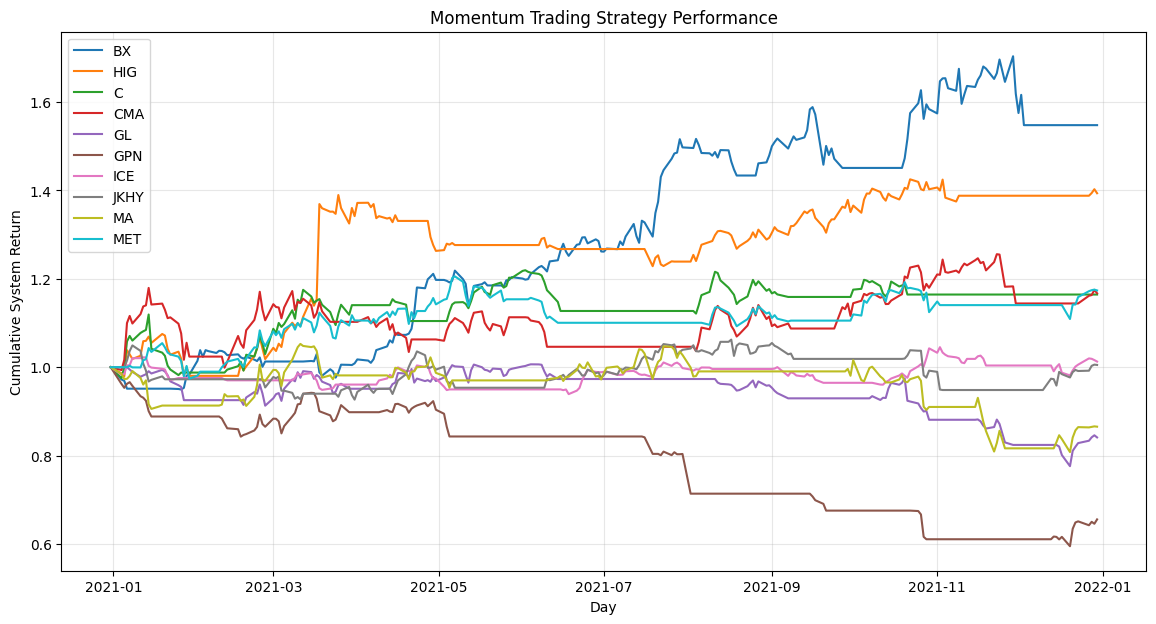

In [ ]:
finance_tickers = 'BX','HIG','C','CMA','GL','GPN','ICE','JKHY','MA','MET'
top_3_stocks= plot_momentum_strategy(finance_tickers, '2020-12-01', '2021-12-31')



From the above graph, we found that BX really took off, with its value jumping up by 60%. HIG did just as well, also growing by 60%. C and CMA made some good progress too, both getting more than a 20% boost. GL's value didn't change much, staying pretty steady. GPN, on the other hand, didn't do so great and ended up worth less than at the start. ICE and JKHY both had a good year, with their values going up by about 40%. MA also had a good climb, finishing 30% higher, while MET went up and down and ended up back where it started.

#### Top 3 stocks in Finance Sector

In [ ]:
print("Top 3 Stocks based on final cumulative returns:")
for stock, return_value in top_3_stocks:
    print(f"{stock}: {return_value*100:.2f}%")

Top 3 Stocks based on final cumulative returns:
BX: 54.77%
HIG: 39.37%
MET: 17.37%


####**Top 3 stocks from the above results(Finance Sector):**
*BX, HIG, MET*

**BX** (Blackstone Group) leads with a 54.77% return, which indicates that an investment in BX would have increased in value by over half again its starting price.

**HIG** (Hartford Financial Services Group) follows with a 39.37% return, showing a significant increase in value and suggesting that it responded well to the momentum trading strategy.

**MET** (MetLife) shows a 17.37% return, which is more modest compared to BX and HIG but still signifies a positive outcome.

### 2.1.3 Momentum Trading Strategy for Materials Sector
We applied the 8-21 momentum trading strategy to these materials sector stocks: 'STLD', 'SHW', 'NUE', 'NEM', 'LYB', 'IFF', 'FCX', 'FMC', 'CE', and 'BALL'.

<ipython-input-80-625a95fe49ca>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(tickers))


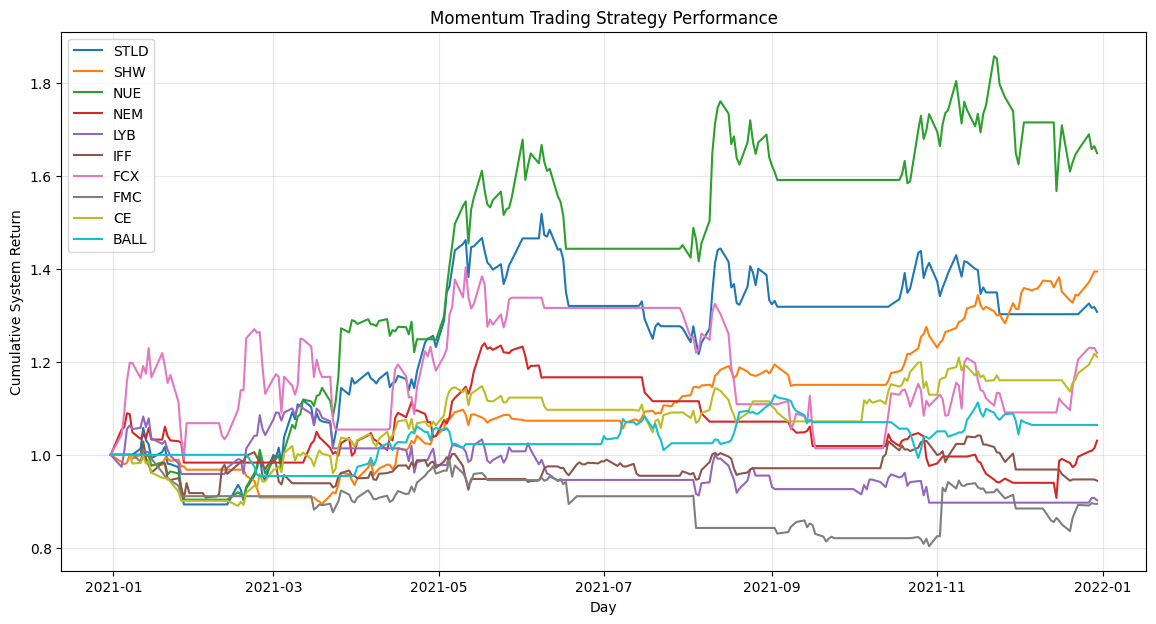

In [ ]:
materials_tickers = 'STLD','SHW','NUE','NEM','LYB','IFF','FCX','FMC','CE','BALL'
top_3_stocks= plot_momentum_strategy(materials_tickers, '2020-12-01', '2021-12-31')


Looking at the materials sector, we can see that STLD and SHW really took off, with their values possibly climbing by more than 80%. NUE also had a strong year, with gains that might be around 60%. Stocks like NEM and FCX went up too, with each of them possibly seeing around a 40% increase. LYB and IFF had more modest rises, maybe in the 20-30% range, while FMC and CE both ended the year with potential gains near 20%. BALL’s value didn't really change, ending the year almost the same as it started. This gives us a clear picture of how different stocks in the materials sector moved over the year.

#### Top 3 stocks in Materials Sector

In [ ]:
print("Top 3 Stocks based on final cumulative returns:")
for stock, return_value in top_3_stocks:
    print(f"{stock}: {return_value*100:.2f}%")

Top 3 Stocks based on final cumulative returns:
NUE: 64.82%
SHW: 39.40%
STLD: 30.71%


####**Top 3 stocks from the above results(Materials Sector):**
*NUE, SHW, STLD*

**NUE:** Nucor Corp took the lead, achieving a 64.82% return. This impressive gain means the stock's value almost doubled, showing the strength of its performance during the period analyzed.

**SHW:** Sherwin-Williams came in second with a solid 39.40% return, indicating its stock value increased by nearly 40%, which marks it as a solid contender in our trading strategy.

**STLD:** Steel Dynamics placed third, with a 30.71% return, translating to a substantial increase of nearly one-third in its stock value from the start of the trading period.

## 2.2 Conclusion
The 8-21 momentum trading strategy proved effective across energy, finance, and materials sectors in 2021, with top performers like FANG, BX, and NUE highlighting its potential in diverse markets.

##**3. Optimization Model**

## 3.1 Selection of Top Stocks from Energy, Finance, and Materials Sectors for Portfolio Analysis

### 3.1.1 Top 9 stocks from all the three sectors:
To analyze the performance of the Energy, Finance, and Materials sectors, we have identified the top 9 stocks from each sector. The selected stocks are as follows:

**Energy Sector:**
1. TRGP (Targa Resources Corp)
2. FANG (Diamondback Energy, Inc)
3. MRO (Marathon Oil Corporation)

**Finance Sector:**
1. BX (The Blackstone Group Inc.)
2. HIG (The Hartford Financial Services Group, Inc.)
3. MET (MetLife, Inc.)

**Materials Sector:**
1. NUE (Nucor Corporation)
2. STLD (Steel Dynamics, Inc.)
3. SHW (Sherwin-Williams Company)

This code block extracts and displays the head of the dataset containing the selected nine stocks (FANG, TRGP, MRO, BX, HIG, MET, NUE, STLD, SHW). This dataset is crucial for the portfolio optimization model, focusing on daily data from January 1, 2017, to December 31, 2021.



In [ ]:
#updated data:
top_stocs_Data = return_data[['FANG','TRGP','MRO','BX','HIG','MET','NUE','STLD','SHW']]
top_stocs_Data.head()


,FANG,TRGP,MRO,BX,HIG,MET,NUE,STLD,SHW
2017-01-04,0.00310,0.00500,0.01633,0.05974,0.01675,0.00553,0.02751,0.04336,0.00677
2017-01-05,0.00097,0.01236,0.00720,0.02081,-0.00412,-0.01374,-0.00571,0.00556,-0.00080
2017-01-06,-0.00010,0.00712,-0.01650,0.00296,0.00207,0.00650,-0.01002,-0.03211,0.01017
2017-01-09,-0.02151,-0.01363,-0.02685,-0.00131,-0.00784,-0.00886,-0.01078,-0.01822,-0.00082
2017-01-10,0.01262,-0.02696,0.00460,-0.01313,0.00749,0.00428,0.02649,0.02853,0.00043


## 3.2 Analytical Calculations

### 3.2.1 Average and Standard Deviation of Daily Returns for Top 9 Stocks:

In this section, we calculate and display the average and standard deviation of daily returns for the selected top 9 stocks across the Energy, Finance, and Materials sectors. The results are presented in the following DataFrames:

## Average Returns:

The average daily returns for each of the top 9 stocks have been computed and stored in the `Avg_Return` DataFrame. This DataFrame is structured with columns representing the stocks and their corresponding average returns.

## Standard Deviation:
Similarly, the standard deviation of daily returns for the selected stocks is calculated and stored in the Std_Dev_Return DataFrame. This DataFrame, like the previous one, is organized with columns representing the stocks and their respective standard deviations.





In [ ]:
Avg_Return = pd.DataFrame(np.mean(top_stocs_Data) ,columns=["Avg_Return"])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(top_stocs_Data) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Avg_Return
FANG     0.00080
TRGP     0.00091
MRO      0.00068
BX       0.00162
HIG      0.00062
MET      0.00058
NUE      0.00087
STLD     0.00086
SHW      0.00124
      Std_Dev_Return
FANG         0.03715
TRGP         0.03716
MRO          0.03633
BX           0.02035
HIG          0.02185
MET          0.02133
NUE          0.02231
STLD         0.02600
SHW          0.01652


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### 3.2.2 Covariance and corelation Analysis

**Covariance Matrix:**
The covariance matrix provides insights into how stock returns move with each other. A positive covariance indicates that stock returns move in the same direction, while a negative covariance suggests they move in opposite directions. Low covariance between assets in a portfolio is preferable as it implies diversification, which can reduce portfolio risk.

In [ ]:
# Here is the covariance matrix
Covariance_matrix = top_stocs_Data.cov()
Covariance_matrix

,FANG,TRGP,MRO,BX,HIG,MET,NUE,STLD,SHW
FANG,0.00138,0.00098,0.00109,0.00030,0.00039,0.00042,0.00040,0.00050,0.00015
TRGP,0.00098,0.00138,0.00092,0.00033,0.00044,0.00039,0.00040,0.00052,0.00019
MRO,0.00109,0.00092,0.00132,0.00029,0.00032,0.00042,0.00041,0.00047,0.00013
BX,0.00030,0.00033,0.00029,0.00041,0.00019,0.00026,0.00022,0.00025,0.00017
HIG,0.00039,0.00044,0.00032,0.00019,0.00048,0.00030,0.00024,0.00031,0.00017
MET,0.00042,0.00039,0.00042,0.00026,0.00030,0.00046,0.00030,0.00033,0.00017
NUE,0.00040,0.00040,0.00041,0.00022,0.00024,0.00030,0.00050,0.00051,0.00017
STLD,0.00050,0.00052,0.00047,0.00025,0.00031,0.00033,0.00051,0.00068,0.00020
SHW,0.00015,0.00019,0.00013,0.00017,0.00017,0.00017,0.00017,0.00020,0.00027


From the covariance matrix, we observe that all covariances are positive,
indicating a general tendency for stock returns to move together to some degree. However, the magnitudes of covariance differ, signifying varying levels of co-movement in returns. For example, the covariance between STLD and NUE is 0.00051, which is lower than the 0.00098 observed between FANG and TRGP. This suggests that STLD and NUE might offer better diversification benefits within a portfolio since their returns are less closely tied together compared to FANG and TRGP, which could lead to a more favorable risk-reduction effect.

Correlation Matrix: The correlation matrix complements this analysis by measuring the strength and direction of the linear relationship between pairs of stocks. A correlation of 1 implies a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 means no linear relationship. Stocks with high positive correlations may not provide significant diversification benefits, while those with low or negative correlations could be better for diversification.

In [ ]:
Corr_matrix = top_stocs_Data.corr()
Corr_matrix

,FANG,TRGP,MRO,BX,HIG,MET,NUE,STLD,SHW
FANG,1.00000,0.70955,0.80987,0.39099,0.47579,0.52703,0.48318,0.51351,0.24948
TRGP,0.70955,1.00000,0.67786,0.43039,0.54592,0.49046,0.47785,0.53594,0.31063
MRO,0.80987,0.67786,1.00000,0.39824,0.40785,0.54690,0.49993,0.49900,0.21684
BX,0.39099,0.43039,0.39824,1.00000,0.42457,0.59860,0.48988,0.47202,0.51484
HIG,0.47579,0.54592,0.40785,0.42457,1.00000,0.64001,0.49633,0.54821,0.47486
MET,0.52703,0.49046,0.54690,0.59860,0.64001,1.00000,0.63947,0.59800,0.47549
NUE,0.48318,0.47785,0.49993,0.48988,0.49633,0.63947,1.00000,0.87671,0.45141
STLD,0.51351,0.53594,0.49900,0.47202,0.54821,0.59800,0.87671,1.00000,0.45372
SHW,0.24948,0.31063,0.21684,0.51484,0.47486,0.47549,0.45141,0.45372,1.00000


The correlation matrix indicates varying degrees of linear relationships among the nine selected stocks, all of which are positive, suggesting that none of the stocks move inversely to one another. Notably, STLD and NUE show a very high correlation of 0.87671, indicating similar price movements and possibly shared market influences, which could limit diversification benefits. Conversely, the lower correlation of 0.24948 between FANG and SHW suggests that these stocks could provide better diversification within a portfolio as their returns are less closely related.

## 3.3 Portfolio optimization model

In [ ]:
#Covariance variable
df_cov = top_stocs_Data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = top_stocs_Data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
        FANG    TRGP     MRO      BX     HIG     MET     NUE    STLD     SHW
FANG 0.00138 0.00098 0.00109 0.00030 0.00039 0.00042 0.00040 0.00050 0.00015
TRGP 0.00098 0.00138 0.00092 0.00033 0.00044 0.00039 0.00040 0.00052 0.00019
MRO  0.00109 0.00092 0.00132 0.00029 0.00032 0.00042 0.00041 0.00047 0.00013
BX   0.00030 0.00033 0.00029 0.00041 0.00019 0.00026 0.00022 0.00025 0.00017
HIG  0.00039 0.00044 0.00032 0.00019 0.00048 0.00030 0.00024 0.00031 0.00017
MET  0.00042 0.00039 0.00042 0.00026 0.00030 0.00046 0.00030 0.00033 0.00017
NUE  0.00040 0.00040 0.00041 0.00022 0.00024 0.00030 0.00050 0.00051 0.00017
STLD 0.00050 0.00052 0.00047 0.00025 0.00031 0.00033 0.00051 0.00068 0.00020
SHW  0.00015 0.00019 0.00013 0.00017 0.00017 0.00017 0.00017 0.00020 0.00027


Average Return:
FANG   0.00080
TRGP   0.00091
MRO    0.00068
BX     0.00162
HIG    0.00062
MET    0.00058
NUE    0.00087
STLD   0.00086
SHW    0.00124
dtype: float64


### 3.3.1 Model Setup

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables
# each one is a stock ('TRGP','EOG','MRO','BX','HIG','MET','NUE','STLD','SHW')
# The fractions are constrained to be non-negative and cannot exceed 1 (100% allocation).

m.FANG = Var(within=NonNegativeReals, bounds=(0,1))
m.TRGP = Var(within=NonNegativeReals, bounds=(0,1))
m.MRO = Var(within=NonNegativeReals, bounds=(0,1))
m.BX = Var(within=NonNegativeReals, bounds=(0,1))
m.HIG = Var(within=NonNegativeReals, bounds=(0,1))
m.MET = Var(within=NonNegativeReals, bounds=(0,1))
m.NUE = Var(within=NonNegativeReals, bounds=(0,1))
m.STLD = Var(within=NonNegativeReals, bounds=(0,1))
m.SHW = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
# declare objective
# We aim to maximize the portfolio's expected return, which is the sum of individual expected returns
# of stocks multiplied by their respective allocation fractions.
m.objective = Objective(expr =
                        m.FANG*df_return[0] +
                        m.TRGP*df_return[1] +
                        m.MRO*df_return[2] +
                        m.BX*df_return[3] +
                        m.HIG*df_return[4] +
                        m.MET*df_return[5]+
                        m.NUE*df_return[6]+
                        m.STLD*df_return[7]+
                        m.SHW*df_return[8],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# Constraint 1: Sum of all proportions = 1 (The sum of allocations across all stocks must equal 1, ensuring all the capital is invested.)

m.sum_proportions = Constraint(expr = m.FANG + m.TRGP + m.MRO + m.BX + m.HIG + m.MET + m.NUE + m.STLD + m.SHW  == 1)

# 2. Set maximum risk: WE ARE INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS (see below), YOU CAN (and should!) IGNORE IT FOR NOW!
m.total_risk = Constraint(expr = m.FANG + m.TRGP + m.MRO + m.BX + m.HIG + m.MET + m.NUE +m.STLD + m.SHW >= 0.0)

### 3.3.2 Risk Level Analysis

This block of code sets up a portfolio optimization problem where the objective is to maximize returns subject to constraints on investment proportions and risk. The risk is defined through a quadratic expression that uses the covariance matrix of the stock returns, allowing for the measurement of the total portfolio risk. The max_risk parameter is a key input that defines the investor's risk tolerance and should be adjusted accordingly. The risk_limits array generates a sequence of potential risk limits to test different levels of risk in the optimization model.

In [ ]:
# creating calculations table for calculate the risk
# 3.Function to Calculate Portfolio Risk:
# The portfolio risk is calculated as a quadratic function based on the covariance between stock returns.

def calc_risk(m):
  variables = m.FANG , m.TRGP , m.MRO , m.BX , m.HIG , m.MET , m.NUE , m.STLD , m.SHW
  tickers = ['FANG','TRGP','MRO','BX','HIG','MET','NUE','STLD','SHW']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk should be less than 0.01
max_risk = 0.00048
# Sequence of risk levels
risk_limits = np.arange(0.00001, max_risk, 0.000003)
risk_limits

array([1.00e-05, 1.30e-05, 1.60e-05, 1.90e-05, 2.20e-05, 2.50e-05,
       2.80e-05, 3.10e-05, 3.40e-05, 3.70e-05, 4.00e-05, 4.30e-05,
       4.60e-05, 4.90e-05, 5.20e-05, 5.50e-05, 5.80e-05, 6.10e-05,
       6.40e-05, 6.70e-05, 7.00e-05, 7.30e-05, 7.60e-05, 7.90e-05,
       8.20e-05, 8.50e-05, 8.80e-05, 9.10e-05, 9.40e-05, 9.70e-05,
       1.00e-04, 1.03e-04, 1.06e-04, 1.09e-04, 1.12e-04, 1.15e-04,
       1.18e-04, 1.21e-04, 1.24e-04, 1.27e-04, 1.30e-04, 1.33e-04,
       1.36e-04, 1.39e-04, 1.42e-04, 1.45e-04, 1.48e-04, 1.51e-04,
       1.54e-04, 1.57e-04, 1.60e-04, 1.63e-04, 1.66e-04, 1.69e-04,
       1.72e-04, 1.75e-04, 1.78e-04, 1.81e-04, 1.84e-04, 1.87e-04,
       1.90e-04, 1.93e-04, 1.96e-04, 1.99e-04, 2.02e-04, 2.05e-04,
       2.08e-04, 2.11e-04, 2.14e-04, 2.17e-04, 2.20e-04, 2.23e-04,
       2.26e-04, 2.29e-04, 2.32e-04, 2.35e-04, 2.38e-04, 2.41e-04,
       2.44e-04, 2.47e-04, 2.50e-04, 2.53e-04, 2.56e-04, 2.59e-04,
       2.62e-04, 2.65e-04, 2.68e-04, 2.71e-04, 2.74e-04, 2.77e

In [ ]:
print(len(risk_limits))

157


 Removal of Infeasible Solutions:

In [ ]:
# Importing the SolverStatus and TerminationCondition for understanding solver outputs
from pyomo.opt import SolverStatus, TerminationCondition

# This section of code is where we iterate over different risk limits to find the optimal stock allocations.
# 'param_analysis' will store the stock allocations for each risk limit, and 'returns' will store the expected returns.

param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # We then solve the optimization problem using the IPOPT solver
  # 'ipopt_executable' should be the path to the IPOPT solver executable on your system
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # We check if the solution is feasible; if not, we skip to the next iteration
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue

  result = result.write()
  # sIf the solution is feasible, we store the allocation proportions in 'param_analysis'
  param_analysis[r] = [m.TRGP() , m.FANG() , m.MRO() , m.BX() , m.HIG() , m.MET() , m.NUE() , m.STLD() , m.SHW()]
  #  We also store the calculated expected returns for this set of allocations in 'returns'
  returns[r] =  m.TRGP()*df_return[0] + m.FANG()*df_return[1] + m.MRO()*df_return[2] + m.BX()*df_return[3] + m.HIG()*df_return[4] +  m.MET()*df_return[5] + m.NUE()*df_return[6] + m.STLD()*df_return[7] + m.SHW()*df_return[8]


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 0.8825929164886475
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Solved To Acceptable Level.
  Termination condition: optimal
  Id: 1
  Error rc: 0
  Time: 0.011454343795776367
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
#

 Parameter Analysis:


In [ ]:
# Let us check the dictionary for the feasiblity
print(param_analysis)

{0.000214: [0.0, 0.0, 0.0019152366584735865, 0.17768814214471607, 0.12934836080681095, 0.03780188242247892, 0.10499231891476522, 0.0, 0.5482540832449173], 0.000226: [0.0, 3.122028035501479e-08, 0.0019192175443770595, 0.1776872196325487, 0.12934745967397157, 0.037800280683074665, 0.1049904919086162, 0.0, 0.5482553101750701], 0.000229: [1.5276621013378798e-06, 4.211827316364744e-06, 4.0040935537933366e-05, 0.252570278092736, 0.09201203730817543, 1.173023541715798e-05, 0.0913902130582674, 2.3881143929278134e-06, 0.5639675727660555], 0.000232: [2.5382538184852972e-06, 8.247730145945797e-06, 5.0205552051160534e-05, 0.2901806273294802, 0.06128516531526933, 8.39428975521743e-06, 0.07561676723444802, 3.929563790813499e-06, 0.572844124731241], 0.000235: [3.2432223326274382e-06, 8.020094202486497e-06, 1.5912805325424137e-05, 0.3171331126660672, 0.0392971852098962, 7.517758867689222e-06, 0.06434481141641092, 5.085687608796035e-06, 0.5791851111392885], 0.000238: [3.985282644463474e-06, 1.297360642

## 3.4 Portfolio Allocations Across Different Risk Levels

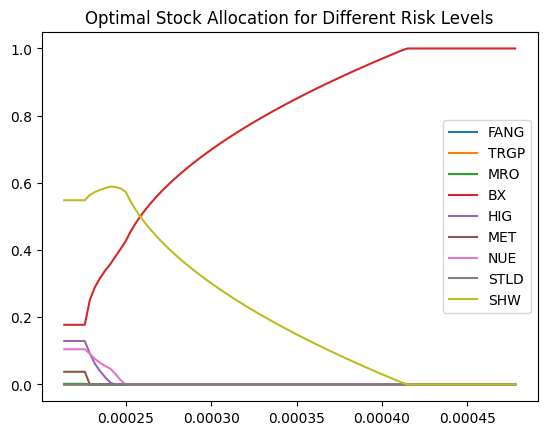

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['FANG','TRGP','MRO','BX','HIG','MET','NUE','STLD','SHW']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

The graph "Optimal Stock Allocation for Different Risk Levels" shows the varying proportions of a portfolio dedicated to nine different stocks at increasing levels of risk, depicted on the x-axis. The red line, representing 'BX', demonstrates a prominent increase in its portfolio share with rising risk, suggesting its role as a high-risk, high-return option. Conversely, 'SHW' the stock indicated by the yellow line, which decreases in allocation as risk increases, is likely preferred in lower-risk settings. Other stocks maintain smaller, steadier allocations, indicating their lesser influence on the portfolio's overall risk or a balanced role across different risk levels. This visualization is key for investors to align their portfolio allocations with their risk preferences.

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.000214, 0.000226, 0.000229, 0.000232, 0.000235, 0.000238, 0.000241, 0.000244, 0.00024700000000000004, 0.00025, 0.000253, 0.00025600000000000004, 0.000259, 0.000262, 0.00026500000000000004, 0.000268, 0.00027100000000000003, 0.00027400000000000005, 0.000277, 0.00028000000000000003, 0.00028300000000000005, 0.000286, 0.00028900000000000003, 0.00029200000000000005, 0.000295, 0.00029800000000000003, 0.00030100000000000005, 0.000304, 0.00030700000000000004, 0.00031000000000000005, 0.000313, 0.00031600000000000004, 0.00031900000000000006, 0.000322, 0.00032500000000000004, 0.00032800000000000006, 0.000331, 0.00033400000000000004, 0.00033700000000000006, 0.00034, 0.00034300000000000004, 0.00034600000000000006, 0.000349, 0.00035200000000000005, 0.000355, 0.00035800000000000003, 0.00036100000000000005, 0.000364, 0.00036700000000000003, 0.00037000000000000005, 0.000373, 0.00037600000000000003, 0.00037900000000000005, 0.000382, 0.00038500000000000003, 0.00038800000000000005, 0.000391, 0.000394000

In [ ]:
print(param_analysis.keys())

Index(['FANG', 'TRGP', 'MRO', 'BX', 'HIG', 'MET', 'NUE', 'STLD', 'SHW'], dtype='object')


In [ ]:
print(param_analysis.head(30))

           FANG    TRGP     MRO      BX     HIG     MET     NUE    STLD  \
0.00021 0.00000 0.00000 0.00192 0.17769 0.12935 0.03780 0.10499 0.00000   
0.00023 0.00000 0.00000 0.00192 0.17769 0.12935 0.03780 0.10499 0.00000   
0.00023 0.00000 0.00000 0.00004 0.25257 0.09201 0.00001 0.09139 0.00000   
0.00023 0.00000 0.00001 0.00005 0.29018 0.06129 0.00001 0.07562 0.00000   
0.00023 0.00000 0.00001 0.00002 0.31713 0.03930 0.00001 0.06434 0.00001   
0.00024 0.00000 0.00001 0.00003 0.33929 0.02119 0.00001 0.05504 0.00001   
0.00024 0.00000 0.00001 0.00001 0.35861 0.00551 0.00001 0.04692 0.00001   
0.00024 0.00000 0.00001 0.00001 0.38107 0.00005 0.00001 0.03117 0.00001   
0.00025 0.00000 0.00000 0.00000 0.40354 0.00001 0.00000 0.01275 0.00000   
0.00025 0.00000 0.00000 0.00000 0.42704 0.00000 0.00000 0.00003 0.00000   
0.00025 0.00000 0.00001 0.00001 0.45657 0.00001 0.00000 0.00002 0.00001   
0.00026 0.00000 0.00001 0.00001 0.48153 0.00001 0.00000 0.00002 0.00001   
0.00026 0.00000 0.00001 0

## 3.5 Plot with Efficent frontier

The efficient frontier plot visualizes the trade-off between risk and return for the different portfolio allocations.

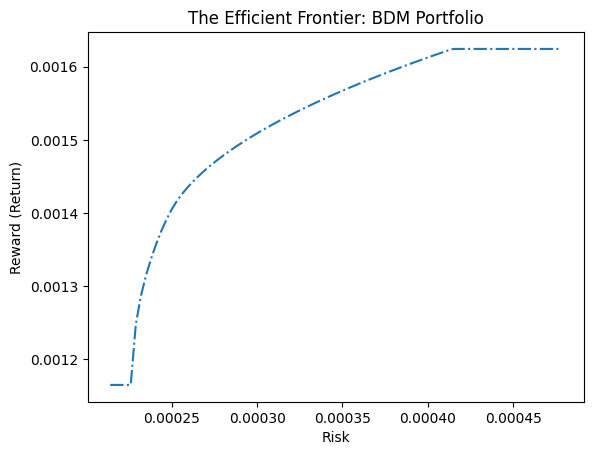

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier: BDM Portfolio')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

The graph illustrates the relationship between risk and return for a set of portfolios comprising the selected stocks. On the x-axis, which represents risk measured by standard deviation, we see values ranging from approximately 0.00025 to beyond 0.00045. The y-axis, representing the expected return of the portfolios, spans from just above 0.0012 to approximately 0.0016.

Observing the curve, we can identify several key points:

1. At lower levels of risk (around 0.00025), the expected return is just above 0.0012.As we move rightward along the x-axis, indicating an increase in risk, the expected return increases. For example, at a risk level of about 0.00030, the return has risen closer to 0.0014.
2. The curve ascends steeply initially, suggesting that small increases in risk correspond to relatively larger increases in expected return.
3. Approaching a risk level of around 0.00040, the return reaches near 0.0016, after which the curve begins to flatten, indicating that further increases in risk do not yield as significant a rise in expected returns. This plateau effect embodies the concept of diminishing marginal returns to risk, a core principle in portfolio theory.

This frontier represents the most efficient portfolios by showing the maximum return that can be achieved for a given level of risk. For an investor, choosing a point on the curve aligns with their risk appetite, where positions on the left-hand side of the curve represent more conservative, lower-risk portfolios and points on the right represent more aggressive, higher-risk portfolios.

## 3.6 Three-Stock Portfolio Allocation Selection



In [ ]:
index_info = param_analysis.index
print("Index info:", index_info)

Index info: Float64Index([              0.000214,               0.000226,
                            0.000229,               0.000232,
                            0.000235,               0.000238,
                            0.000241,               0.000244,
              0.00024700000000000004,                0.00025,
                            0.000253, 0.00025600000000000004,
                            0.000259,               0.000262,
              0.00026500000000000004,               0.000268,
              0.00027100000000000003, 0.00027400000000000005,
                            0.000277, 0.00028000000000000003,
              0.00028300000000000005,               0.000286,
              0.00028900000000000003, 0.00029200000000000005,
                            0.000295, 0.00029800000000000003,
              0.00030100000000000005,               0.000304,
              0.00030700000000000004, 0.00031000000000000005,
                            0.000313, 0.000316000000000000

In [ ]:
print(param_analysis.loc[ 0.000241])

FANG   0.00000
TRGP   0.00001
MRO    0.00001
BX     0.35861
HIG    0.00551
MET    0.00001
NUE    0.04692
STLD   0.00001
SHW    0.58892
Name: 0.000241, dtype: float64


In [ ]:
# Selecting 3 portfolios from the above risk level allocations
selection_pf=param_analysis.loc[0.000241, ['SHW', 'NUE', 'BX']]
selection_pf = pd.DataFrame({'Allocation': selection_pf})
selection_pf


,Allocation
SHW,0.58892
NUE,0.04692
BX,0.35861



At the risk level of 0.000241, the optimization model suggests a portfolio allocation of 58.8892% in 'SHW', 4.0692% in 'NUE', and 35.8861% in 'BX'. This allocation reflects the model's strategy for obtaining the optimal balance of risk and return, assigning the majority of the portfolio to 'SHW', a substantial portion to 'BX', and a smaller investment in 'NUE'.

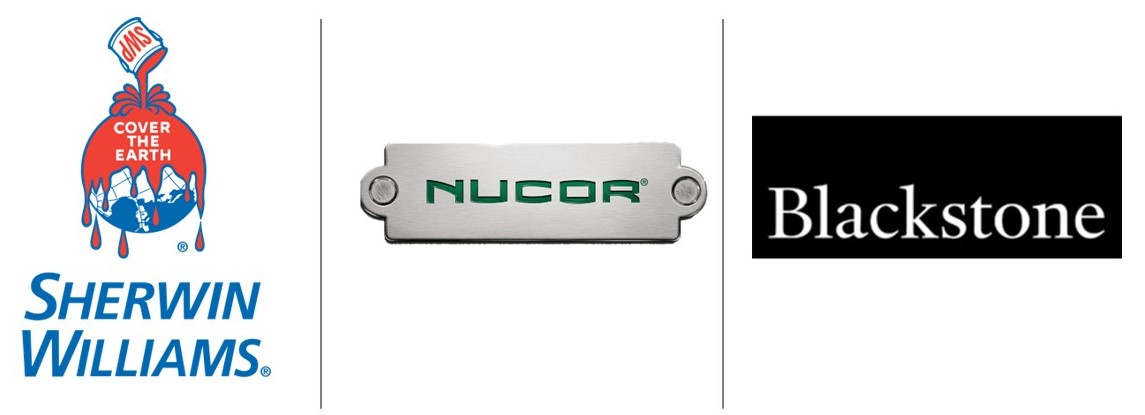

# 4 - Analysis

Evaluating the following investments strategies using data from the year 2022:
1. Buy and Hold Strategy for MPT Portfolio
2. Momentum Trading Strategy for ^GSPC
3. Buy and Hol Strategy for ^GSPC



## 4.1 Buy-and-Hold Strategy for the MPT Portfolio

 We have used below code to fetch the historical data for a set of stocks, specifically 'SHW', 'NUE', and 'BX', which have been selected as the top trades by the optimized model. The time frame for data retrieval is set from January 1, 2022, to December 2, 2022.  

In [ ]:
# Defining the ticker symbols from the optimized model
tickerlst = ['SHW', 'NUE', 'BX']

# Defining the date ranges
start_date = '2022/01/01'
end_date = '2022/12/02'

# Extracting the historical data for each ticker
dfs = {ticker: si.get_data(ticker,start_date = start_date,end_date=end_date,interval='1mo') for ticker in tickerlst}
dfs

{'SHW':                 open      high       low     close  adjclose    volume ticker
 2022-01-01 348.48001 350.39001 273.78000 286.51001 281.00540  40026200    SHW
 2022-02-01 288.73001 295.75000 251.42999 263.13000 258.07462  27405200    SHW
 2022-03-01 261.51999 264.42999 233.32001 249.62000 245.39275  36190900    SHW
 2022-04-01 251.36000 285.00000 240.70000 274.95999 270.30359  36686100    SHW
 2022-05-01 273.79999 283.14999 250.17999 268.04001 263.50079  40329900    SHW
 2022-06-01 270.12000 278.31000 214.22000 223.91000 220.62796  36277900    SHW
 2022-07-01 225.00000 263.23999 220.74001 241.94000 238.39366  35556100    SHW
 2022-08-01 240.38000 258.92001 231.64000 232.10001 228.69789  34592200    SHW
 2022-09-01 231.09000 244.82001 204.57001 204.75000 202.23131  30326600    SHW
 2022-10-01 206.84000 228.57001 195.24001 225.03000 222.26183  33494200    SHW
 2022-11-01 227.03999 250.06000 211.87000 249.17999 246.11475  35059900    SHW
 2022-12-01 253.31000 265.64001 235.11000 237


Consolidated the closing prices for 'SHW', 'NUE', and 'BX' into a new DataFrame called dfm. It extracts the 'close' data from each stock's historical data in dfs and assigns new column names corresponding to each stock with a '_close' suffix.

In [ ]:
# Appending close column with its respective ticker
dfm = pd.DataFrame()
for i in tickerlst:
  dfm[i] = pd.DataFrame(dfs[i]['close'])
dfm.columns = ['SHW_close', 'NUE_close', 'BX_close']
dfm.head()

,SHW_close,NUE_close,BX_close
2022-01-01,286.51001,101.40000,131.97000
2022-02-01,263.13000,131.62000,127.47000
2022-03-01,249.62000,148.64999,126.94000
2022-04-01,274.95999,154.78000,101.57000
2022-05-01,268.04001,132.46001,117.79000


To normalize our price data, we've applied a logarithmic transformation to the closing prices. This is a common technique in financial analysis to stabilize the variance. We then calculated the returns for each stock by finding the difference in these log values. This step is key to understanding how each stock's value changes over time.

In [ ]:
# Applying log to close
dfm['SHW_logClose'] = np.log(dfm['SHW_close'])
dfm['NUE_logClose'] = np.log(dfm['NUE_close'])
dfm['BX_logClose'] = np.log(dfm['BX_close'])
dfm.head()

,SHW_close,NUE_close,BX_close,SHW_logClose,NUE_logClose,BX_logClose
2022-01-01,286.51001,101.40000,131.97000,5.65777,4.61907,4.88257
2022-02-01,263.13000,131.62000,127.47000,5.57265,4.87992,4.84788
2022-03-01,249.62000,148.64999,126.94000,5.51994,5.00159,4.84371
2022-04-01,274.95999,154.78000,101.57000,5.61663,5.04200,4.62075
2022-05-01,268.04001,132.46001,117.79000,5.59114,4.88628,4.76890


The function `.diff()` calculates the difference between the current row and previous row. That's why there is a `NaN` at the beginning of the dataframe when we create the `SHW['return']` column.

We want to calculate the returns using `.diff()`, so we need to take the log of the close values. `SHW['return']`,NUE['return'],BX['return'] will be the **'buy and hold' return** (i.e., we will buy in the first day and sell in the last day, regardless of what's happening in the market). And later, we will make a variable for our system, the momentum trading algorithm!

In [ ]:
# Calculating the returns for each stock
dfm['SHW_return'] = dfm['SHW_logClose'].diff()
dfm['NUE_return'] = dfm['NUE_logClose'].diff()
dfm['BX_return'] = dfm['BX_logClose'].diff()
dfm.head()

,SHW_close,NUE_close,BX_close,SHW_logClose,NUE_logClose,BX_logClose,SHW_return,NUE_return,BX_return
2022-01-01,286.51001,101.40000,131.97000,5.65777,4.61907,4.88257,NaN,NaN,NaN
2022-02-01,263.13000,131.62000,127.47000,5.57265,4.87992,4.84788,-0.08513,0.26085,-0.03469
2022-03-01,249.62000,148.64999,126.94000,5.51994,5.00159,4.84371,-0.05271,0.12168,-0.00417
2022-04-01,274.95999,154.78000,101.57000,5.61663,5.04200,4.62075,0.09669,0.04041,-0.22297
2022-05-01,268.04001,132.46001,117.79000,5.59114,4.88628,4.76890,-0.02549,-0.15572,0.14816


In this case, instead of deleting the first row, we have set the return to 0.0.

In [ ]:
# Making value with Nan to 0
dfm['SHW_return'].iloc[0] = 0.0
dfm['NUE_return'].iloc[0] = 0.0
dfm['BX_return'].iloc[0] = 0.0
print(dfm.head())

            SHW_close  NUE_close  BX_close  SHW_logClose  NUE_logClose  \
2022-01-01  286.51001  101.40000 131.97000       5.65777       4.61907   
2022-02-01  263.13000  131.62000 127.47000       5.57265       4.87992   
2022-03-01  249.62000  148.64999 126.94000       5.51994       5.00159   
2022-04-01  274.95999  154.78000 101.57000       5.61663       5.04200   
2022-05-01  268.04001  132.46001 117.79000       5.59114       4.88628   

            BX_logClose  SHW_return  NUE_return  BX_return  
2022-01-01      4.88257     0.00000     0.00000    0.00000  
2022-02-01      4.84788    -0.08513     0.26085   -0.03469  
2022-03-01      4.84371    -0.05271     0.12168   -0.00417  
2022-04-01      4.62075     0.09669     0.04041   -0.22297  
2022-05-01      4.76890    -0.02549    -0.15572    0.14816  


In [ ]:
df_log = dfm[['SHW_return', 'NUE_return', 'BX_return']]
df_log.head()

,SHW_return,NUE_return,BX_return
2022-01-01,0.00000,0.00000,0.00000
2022-02-01,-0.08513,0.26085,-0.03469
2022-03-01,-0.05271,0.12168,-0.00417
2022-04-01,0.09669,0.04041,-0.22297
2022-05-01,-0.02549,-0.15572,0.14816


Calculating profit/loss for the invested amount for the assessts based on the weights from their portfolio

Here, we've set an initial investment amount and assigned weights to each stock based on their portfolio allocation. This is where we calculate the actual money invested in each asset. Then, we've calculated the cumulative returns to show how our investment would have grown over time. This is a crucial step in evaluating the effectiveness of our buy-and-hold strategy.

In [ ]:
startinginvestment = 100000
wghts = [0.58891,0.04690, 0.35862]
df_log.loc["2022-01-01"] =  [(i*startinginvestment)-1 for i in wghts]

In [ ]:
print(df_log)

            SHW_return  NUE_return   BX_return
2022-01-01 58890.00000  4689.00000 35861.00000
2022-02-01    -0.08513     0.26085    -0.03469
2022-03-01    -0.05271     0.12168    -0.00417
2022-04-01     0.09669     0.04041    -0.22297
2022-05-01    -0.02549    -0.15572     0.14816
2022-06-01    -0.17989    -0.23796    -0.25552
2022-07-01     0.07745     0.26286     0.11228
2022-08-01    -0.04152    -0.02129    -0.08300
2022-09-01    -0.12538    -0.21716    -0.11542
2022-10-01     0.09444     0.20536     0.08516
2022-11-01     0.10194     0.13221     0.00427
2022-12-01    -0.04872    -0.12894    -0.21004


Calculating cumulative return till the date

In [ ]:
Monthly_BH_Values = (1 + df_log).cumprod()
Monthly_BH_Values

,SHW_return,NUE_return,BX_return
2022-01-01,58891.00000,4690.00000,35862.00000
2022-02-01,53877.88899,5913.36699,34617.81880
2022-03-01,51038.06718,6632.87924,34473.58369
2022-04-01,55972.72658,6900.91547,26787.13490
2022-05-01,54546.01836,5826.27743,30755.78750
2022-06-01,44733.62312,4439.88400,22897.08225
2022-07-01,48198.04405,5606.94190,25467.85267
2022-08-01,46196.79224,5487.59634,23353.95614
2022-09-01,40404.70233,4295.89585,20658.50405
2022-10-01,44220.68397,5178.09489,22417.73759


Finally, we've aggregated these cumulative returns across all stocks to get a comprehensive view of the portfolio's performance. This aggregate value will give us a clear picture of the overall growth of our investment over the selected period.

In [ ]:
Monthly_BH_Values['Aggregate'] = Monthly_BH_Values.sum(axis=1)
Monthly_BH_Values

,SHW_return,NUE_return,BX_return,Aggregate
2022-01-01,58891.00000,4690.00000,35862.00000,99443.00000
2022-02-01,53877.88899,5913.36699,34617.81880,94409.07478
2022-03-01,51038.06718,6632.87924,34473.58369,92144.53011
2022-04-01,55972.72658,6900.91547,26787.13490,89660.77694
2022-05-01,54546.01836,5826.27743,30755.78750,91128.08329
2022-06-01,44733.62312,4439.88400,22897.08225,72070.58937
2022-07-01,48198.04405,5606.94190,25467.85267,79272.83863
2022-08-01,46196.79224,5487.59634,23353.95614,75038.34473
2022-09-01,40404.70233,4295.89585,20658.50405,65359.10222
2022-10-01,44220.68397,5178.09489,22417.73759,71816.51645


 The above output where an initial investment of 100,000 dollars is allocated across three stocks—SHW, NUE, and BX—based on the weights determined by the optimized portfolio model. The allocation percentages are 58.891% for SHW, 4.069% for NUE, and 35.862% for BX. This results in an initial investment of 58,891 dollars in SHW, 4,690 dollars in NUE, and 35,862 dollars in BX.

The table represents the cumulative returns for each stock over time. For instance, on January 1, 2022, the investment values are as listed above. By February 1, 2022, the values have changed to 53,877.8889 dollars for SHW, 5,913.36699 dollars for NUE, and 34,617.81880 dollars for BX, indicating a change in value based on the returns of each stock.

As the months progress, the values fluctuate, reflecting the performance of the stocks. For example, by November 1, 2022, the amounts have changed to 48,728.61905 dollars for SHW, 5,862.68025 dollars for NUE, and 2,2513.46122 dollars for BX.

These figures represent the value of the investments in each stock on the first day of each month, providing insight into how the initial allocations have fared across the year due to market movements and the respective returns of each stock.

## 4.2 - Momentum Trading Strategy for S&P 500

Now , we're going to analyze a momentum trading strategy applied to the S&P 500
index ^GSPC for the year 2022. We'll use the 8-21 day moving average crossover as our strategy indicator.

In [ ]:
# Download S&P 500 index data
ticker = '^GSPC'

sp500 = si.get_data(ticker,start_date = '2021/12/02',end_date='2022/12/02',interval='1d')

In [ ]:
sp500

,open,high,low,close,adjclose,volume,ticker
2021-12-02,4504.72998,4595.45996,4504.72998,4577.10010,4577.10010,5077180000,^GSPC
2021-12-03,4589.49023,4608.02979,4495.12012,4538.43018,4538.43018,5240070000,^GSPC
2021-12-06,4548.37012,4612.60010,4540.50977,4591.66992,4591.66992,4770800000,^GSPC
2021-12-07,4631.97021,4694.04004,4631.97021,4686.75000,4686.75000,4492400000,^GSPC
2021-12-08,4690.85986,4705.06006,4674.52002,4701.20996,4701.20996,4234600000,^GSPC
...,...,...,...,...,...,...,...
2022-11-25,4023.34009,4034.02002,4020.76001,4026.12012,4026.12012,1706460000,^GSPC
2022-11-28,4005.36011,4012.27002,3955.77002,3963.93994,3963.93994,3615430000,^GSPC
2022-11-29,3964.18994,3976.77002,3937.64990,3957.62988,3957.62988,3546040000,^GSPC
2022-11-30,3957.17993,4080.11011,3938.58008,4080.11011,4080.11011,6579360000,^GSPC


 `sp500['Close'].rolling(8).mean().shift()` , * `sp500['Close'].rolling(21).mean().shift()` uses the previous 9 day moving average and 21 day average  to make its decision for tomorrow's trading dayuses the previous 9 day and 21 day moving average to make its decision for tomorrow's trading day

In [ ]:
sp500['8-day'] = sp500['close'].rolling(8).mean().shift()
sp500['21-day'] = sp500['close'].rolling(21).mean().shift()
sp500.dropna(inplace=True)

In [ ]:
sp500['logClose'] = np.log(sp500['close']) # price will always be positive, so this operation is well-defined
sp500['return'] = sp500['logClose'].diff() # the difference will be positive or negative

**Entering and leaving the market using the momentum trading strategy**

Now we make a column called 'signal' which tells you when you enter and leave the market based on the momentum trading strategy. Remember that we want to **buy/sell at the transition points**, i.e., when the plots are intersecting and the trend is changing.

A value of +1 indicates that we should buy, and a value of -1 indicates that we should sell. Observe that this happens when the trend flips.

In [ ]:
# the np.where() function is similar to the Excel =IF() statement
sp500['invested'] = np.where(sp500['8-day'] > sp500['21-day'], 1, 0)

# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
sp500['signal'] = sp500['invested'].diff()
print(sp500['signal'].value_counts())


0.00000     220
-1.00000      5
1.00000       5
Name: signal, dtype: int64


On the first day of our data set, we've set the 'signal' to 1.0, indicating a buy. This aligns with our strategy's requirement to potentially buy on January 1, 2022. We've also ensured that the first return value is set to 0.0 since there's no previous day to compare to.

In [ ]:
# Buying on the fisrt day
# Setting row with Nan to 1 for signal
sp500['signal'].iloc[0] = 1.0

In [ ]:
sp500['return'] = np.log(sp500['close']).diff()
sp500['return'].iloc[0] = 0.0

We've computed 'system_return' to reflect the profit or loss from our momentum trading strategy. This figure multiplies the daily 'invested' signal by the daily 'return'.


In [ ]:
# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
sp500['system_return'] = sp500['invested'] * sp500['return']
sp500.head()

,open,high,low,close,adjclose,volume,ticker,8-day,21-day,logClose,return,invested,signal,system_return
2022-01-03,4778.14014,4796.64014,4758.16992,4796.56006,4796.56006,3831020000,^GSPC,4748.38629,4682.47433,8.47565,0.00000,1,1.00000,0.00000
2022-01-04,4804.50977,4818.62012,4774.27002,4793.54004,4793.54004,4683170000,^GSPC,4766.80255,4692.92480,8.47502,-0.00063,1,0.00000,-0.00063
2022-01-05,4787.99023,4797.70020,4699.43994,4700.58008,4700.58008,4887960000,^GSPC,4778.92505,4705.07289,8.45544,-0.01958,1,0.00000,-0.01958
2022-01-06,4693.39014,4725.00977,4671.25977,4696.04980,4696.04980,4295280000,^GSPC,4775.77380,4710.25909,8.45448,-0.00096,1,0.00000,-0.00096
2022-01-07,4697.66016,4707.95020,4662.74023,4677.02979,4677.02979,4181510000,^GSPC,4763.88129,4710.70194,8.45042,-0.00406,1,0.00000,-0.00406


From there, we've calculated the cumulative return to see the growth of our strategy over time.Starting with an initial investment of $100,000, we've applied our cumulative returns to this amount to get the 'investment_value'. This column shows the value of our investment throughout the year.


In [ ]:
# Calculate cumulative returns and value of the $100,000 investment
initial_investment = 100000
sp500['cumulative_return'] = (1 + sp500['system_return']).cumprod()
sp500['investment_value'] = initial_investment * sp500['cumulative_return']


In [ ]:
sp500['investment_value']

2022-01-03   100000.00000
2022-01-04    99937.01797
2022-01-05    97979.92494
2022-01-06    97885.44939
2022-01-07    97488.18706
                 ...     
2022-11-25    89090.84150
2022-11-28    87704.16956
2022-11-29    87564.44509
2022-11-30    90233.29060
2022-12-01    90154.96722
Name: investment_value, Length: 231, dtype: float64

Lastly, we've resampled our 'investment_value' data to extract the value on the first day of each month. This gives us a clear month-by-month overview of the investment's performance.

In [ ]:
# Extracting the investment value on the first day of each month
monthly_MT_values = sp500['investment_value'].resample('MS').first()
monthly_MT_values  # Display the monthly investment values

2022-01-01   100000.00000
2022-02-01    97098.40795
2022-03-01    91985.72447
2022-04-01    93684.59602
2022-05-01    91603.31129
2022-06-01    91603.31129
2022-07-01    81777.10357
2022-08-01    86255.62805
2022-09-01    84276.77024
2022-10-01    84276.77024
2022-11-01    85537.83802
2022-12-01    90154.96722
Freq: MS, Name: investment_value, dtype: float64

With this analysis complete, we now have a table that shows how our investment would have changed on the first day of each month throughout 2022, using the 8-21 Momentum Trading strategy on the S&P 500 index.  Throughout the year, the investment value fluctuated, showing both gains and losses. The strategy did not consistently increase the investment's value, which is common in momentum trading due to market volatility and trend reversals.

By December 1, 2022, the investment value was lower than the initial $100,000, which indicates that the 8-21 Momentum Trading strategy would have resulted in a loss over the year. However, this is a simplistic assessment and does not account for other factors.

## 4.3 - Buy-and-Hold strategy for the S&P 500 index

Firstly, we've downloaded the S&P 500 index data starting from January 1, 2022, until December 2, 2022. We're focusing on monthly data to align with our evaluation points on the first day of each month. The data is pared down to just the 'close' prices.

In [ ]:
# Download S&P 500 index data
ticker = '^GSPC'

sp500 = si.get_data(ticker,start_date = '2022/01/01',end_date='2022/12/02',interval='1mo')
sp500 = sp500[['close']]
sp500.columns = ['sp500_close']
sp500.head()

,sp500_close
2022-01-01,4515.54980
2022-02-01,4373.93994
2022-03-01,4530.41016
2022-04-01,4131.93018
2022-05-01,4132.14990


After isolating the closing prices, we've applied a logarithmic transformation to these values. This is a common practice in financial analysis, as it helps to stabilize the variance in price data. We then calculate the monthly returns, which will be positive or negative based on the change in log-close values.

In [ ]:
sp500['sp500_logClose'] = np.log(sp500['sp500_close']) # price will always be positive
sp500['sp500_return'] = sp500['sp500_logClose'].diff() # the difference might be positive/negative
sp500.head()

,sp500_close,sp500_logClose,sp500_return
2022-01-01,4515.54980,8.41528,NaN
2022-02-01,4373.93994,8.38342,-0.03186
2022-03-01,4530.41016,8.41857,0.03515
2022-04-01,4131.93018,8.32650,-0.09207
2022-05-01,4132.14990,8.32655,0.00005


We corrected the first return value to be 0.0 because there's no previous month to compare it to on the starting date. We then created a DataFrame, sp500_returns, to holding these return values.

In [ ]:
sp500['sp500_return'].iloc[0]=0.0
sp500_returns = pd.DataFrame(sp500["sp500_return"])

We set our initial investment at $99,999. This figure is inserted into the sp500_returns DataFrame on the date '2022-01-01' to simulate our investment allocation.We've calculated cumulative product of (1 + returns), which represents the cumulative growth factor of our investment over time. This simulates the buy-and-hold strategy by showing how our initial investment would have compounded.

In [ ]:
startinginvestment = 99999
sp500_returns.loc["2022-01-01"] =  [startinginvestment]
Monthly_BH_Values_SP = (1 + sp500_returns).cumprod()
Monthly_BH_Values_SP

,sp500_return
2022-01-01,100000.00000
2022-02-01,96813.72390
2022-03-01,100216.56038
2022-04-01,90989.83965
2022-05-01,90994.67815
2022-06-01,83018.85067
2022-07-01,90258.20941
2022-08-01,86343.97887
2022-09-01,77878.02370
2022-10-01,83861.74773


We started 2022 with an investment of 99,999  dollars in the SP 500 index and followed a buy and hold strategy. Initially, our investment stood at 100,000 dollars but dipped to 96,813.72  dollars by February. It fluctuated throughout the year, peaking slightly in March at 100,216.56 dollars and then falling to a low of 77,878.02 dollars in September. Despite some recovery in the following months, by December 1st, our investment value settled at 82,888.43 dollars, marking an overall decrease from the beginning of the year.

## 4.4 - Plot Comparing the Investment Strategies

In [ ]:
# Define a function to plot a single return series for the Buy and Hold strategy
def plot_single_return(data, title, label):
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(data, marker='o', label=label)  # Plot the data with markers
    plt.title(title)  # Set the plot title
    plt.xlabel('Month')  # Set the x-axis label
    plt.ylabel('Return')  # Set the y-axis label
    plt.legend(loc=2)  # Place the legend
    plt.grid(True, alpha=0.3)  # Enable the grid
    plt.xticks(rotation=45)  # Rotate the x-axis labels
    plt.tight_layout()  # Adjust the layout
    plt.show()

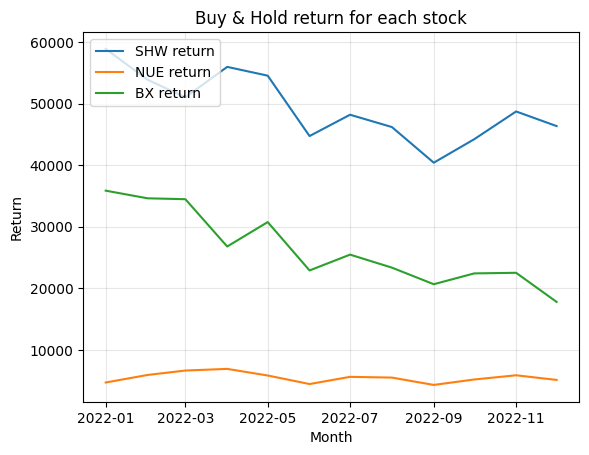

In [ ]:
# Plot for each stock return in Buy and Hold
plt.plot(Monthly_BH_Values['SHW_return'], label='SHW return')
plt.plot(Monthly_BH_Values['NUE_return'], label='NUE return')
plt.plot(Monthly_BH_Values['BX_return'], label='BX return')
plt.legend(loc=2)
plt.title('Buy & Hold return for each stock')
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid(True, alpha=.3)
plt.show()

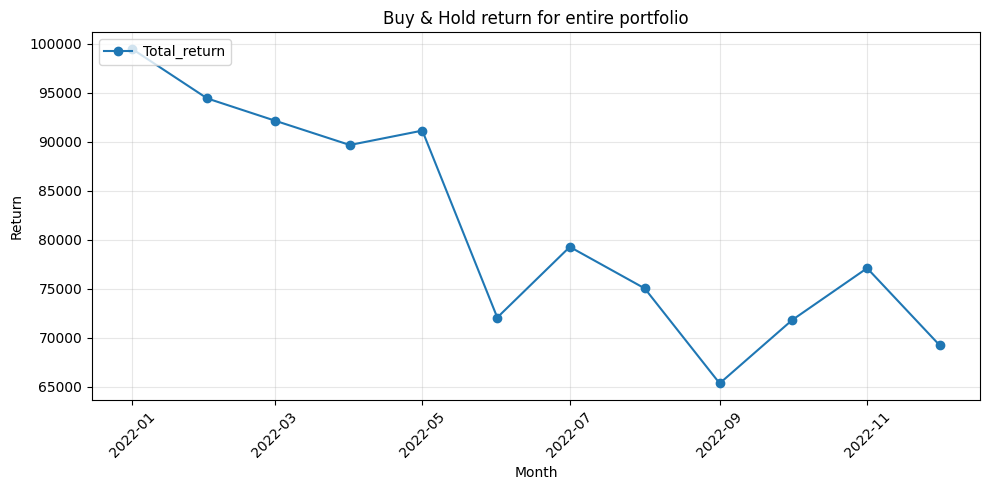

In [ ]:

# Example usage of the function:
plot_single_return(
     Monthly_BH_Values['Aggregate'],
     'Buy & Hold return for entire portfolio',
     'Total_return'
 )

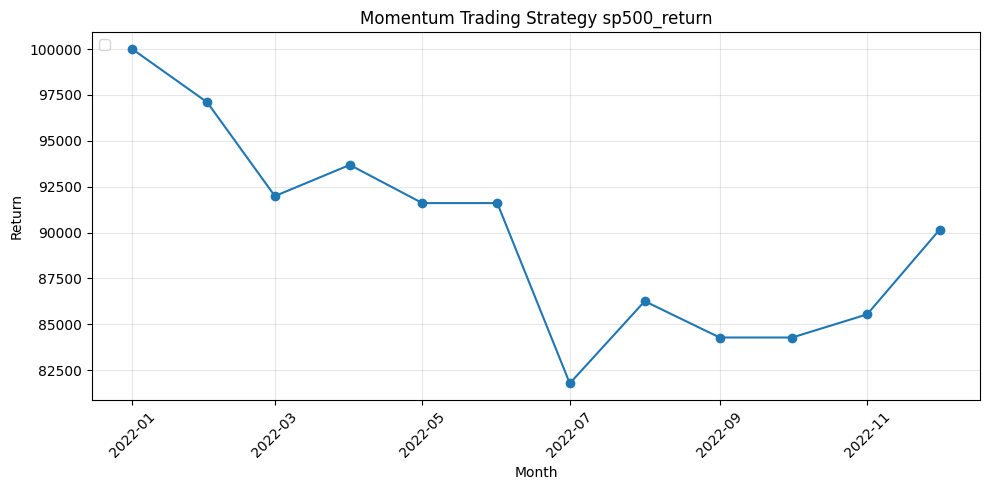

In [ ]:

# Example usage of the function:
plot_single_return(
     monthly_MT_values,
     'Momentum Trading Strategy sp500_return',
     ''
 )

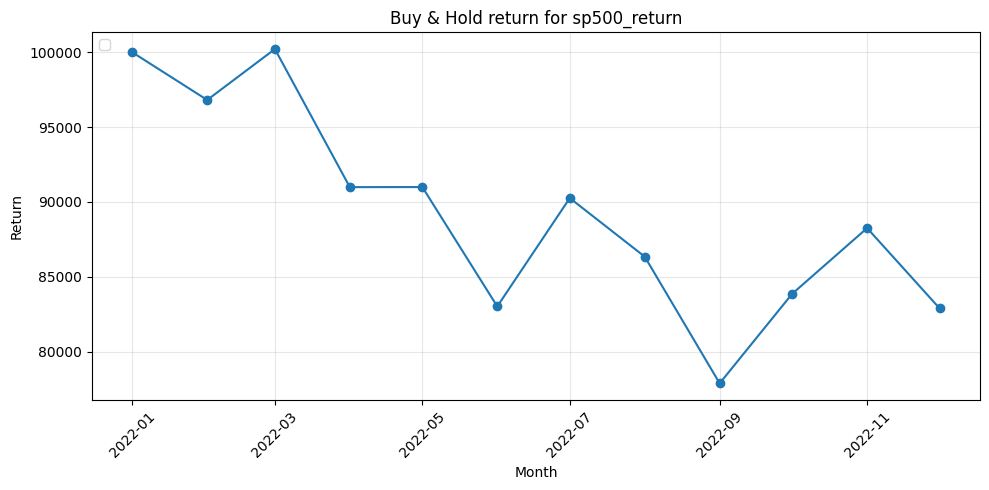

In [ ]:

# Example usage of the function:
plot_single_return(
     Monthly_BH_Values_SP["sp500_return"],
     'Buy & Hold return for sp500_return',
     ''

 )

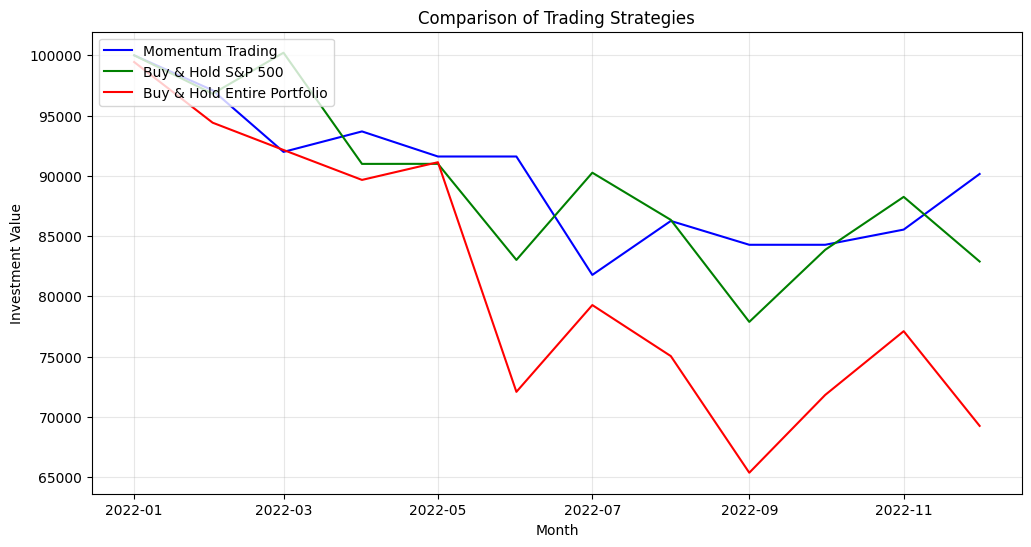

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for Momentum Trading Strategy
plt.plot(monthly_MT_values, label='Momentum Trading', color='blue')

# Plot for Buy & Hold S&P 500 (using the same data for this demonstration)
plt.plot(Monthly_BH_Values_SP["sp500_return"], label='Buy & Hold S&P 500', color='green')

# Plot for Buy & Hold Entire Portfolio (using the same data for this demonstration)
plt.plot(Monthly_BH_Values['Aggregate'], label='Buy & Hold Entire Portfolio', color='red')

# Adding legends, title, and labels
plt.legend(loc=2)
plt.title('Comparison of Trading Strategies')
plt.xlabel('Month')
plt.ylabel('Investment Value')
plt.grid(True, alpha=.3)

# Show the plot
plt.show()

Above graph showcases a line graph comparing the performance of three different investment strategies over the course of 2022. These strategies are "Momentum Trading," "Buy & Hold S&P 500," and "Buy & Hold Entire Portfolio."

Here's an analysis of the results based on the graph:

Momentum Trading (Blue Line): This strategy shows fluctuations throughout the year. It starts off above the $90,000 mark, dips below in the middle of the year, and then recovers towards the end, closing slightly below where it started. The strategy seems volatile, reflecting the nature of momentum trading which capitalizes on short-term trends.

Buy & Hold S&P 500 (Green Line): The buy-and-hold strategy with just the S&P 500 index starts at the same level as the other strategies but shows a steady decline over the year, finishing off with the lowest value among the three strategies. This suggests that the S&P 500 index might have had a downward trend throughout the year.

Buy & Hold Entire Portfolio (Red Line): This strategy begins on par with the others but experiences the sharpest decline early in the year. It then partially recovers but suffers another significant drop towards the end of the period. This could indicate that the portfolio had a few assets that underperformed or were particularly volatile.

**Comparative Analysis:**

**Risk and Volatility:** The momentum trading strategy, while volatile, ended the period better than the buy-and-hold S&P 500 strategy, suggesting that it could handle the market's ups and downs relatively well.

**Overall Performance:** The buy-and-hold strategy for the entire portfolio shows that diversification might not always protect against market downturns, as it had the most significant drops during the year.

**Market Trends**: The consistent decline of the S&P 500 strategy hints at a bearish trend for the index in 2022, which negatively impacted the performance of the buy-and-hold strategies.

# 5 - Conclusion

## 5.1 - Thoughts and Insights

* In the optimization model, the allocation changes for the given risk tolerance. For less risk tolerance, more diversified the portfolio would be and vice versa.
* Diversification in an investment portfolio does not always guarantee better performance, as seen from the volatility in the "Buy & Hold Entire Portfolio" strategy.
* The "Momentum Trading" strategy's recovery towards the end of the year suggests it may be resilient to short-term market shocks, perhaps due to the dynamic nature of the strategy allowing for adjustment to market trends.
* The steady decline of the "Buy & Hold S&P 500" strategy indicates the importance of market timing and selection, especially in a year where the index trends downward.
* The comparative analysis highlights the necessity of re-evaluating investment strategies periodically, as different market conditions can significantly impact performance.
* The performance of the "Buy & Hold Entire Portfolio" strategy suggests that the selected assets could have included high-beta stocks, which tend to amplify market movements.
* The "Momentum Trading" strategy's performance relative to the others indicates that active management can sometimes outperform passive strategies, depending on market conditions.
* The analysis teaches the importance of considering transaction costs, which could further differentiate the performance of these strategies, especially for the "Momentum Trading" which typically involves more frequent trading.
* If one can identify a decent risk-management strategy, he could protect the portfolio from a bigger decline. For example, the strategy of selling stocks if 8 day MA goes below 21 day MA, would have really helped an investor to protect value of the portfolio by staying out of market.




## 5.2 - Individual Contributions

1. Sai Deepika Bandari - Optimization Model,Analysis  & Video Recording
2. Jasmitha Chinta - Data Preparation
3. Moulika Narne - Analysis Buy and Hold Starategy
4. Yasvanth Pamidi - Data visualization
5. Irfan Ahmed Shaik - Optimization Model and Document formatting.
6. Sushma Vavilala - Momentum Trading Strategy
